In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pystan 
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import pickle
from tqdm.notebook import tqdm as tqdm
import math
from scipy.stats import gaussian_kde

In [2]:
data = pd.read_csv('Cam_all_55ºC_2023_02_22.csv')
data = data[(data["Strain_Name"]!="RIMD 0366027")&(data["Strain_Name"]!="RIMD 0366043")]
data["ID_strain_II"] = (data["ID_strain"] != data["ID_strain"].shift(1)).cumsum()
data["ID_strain_origin"] = data["ID_strain"]
data["ID_strain"] = data["ID_strain_II"]
data = data.drop("ID_strain_II", axis=1)

pd.set_option('display.max_rows', None)
data

Strain_Name  ID_strain  rep_ID  t_heat  n_dilu         V  non_detect  \
0      ATCC 33250          1       1    0.00       3  0.000540           0   
1      ATCC 33250          1       1    0.00       3  0.000540           0   
2      ATCC 33250          1       2    0.00       3  0.000540           0   
3      ATCC 33250          1       2    0.00       3  0.000540           0   
4      ATCC 33250          1       3    0.00       3  0.000540           0   
5      ATCC 33250          1       3    0.00       3  0.000540           0   
6      ATCC 33250          1       1    2.25       2  0.000540           0   
7      ATCC 33250          1       1    2.25       2  0.000540           0   
8      ATCC 33250          1       2    2.25       2  0.000540           0   
9      ATCC 33250          1       2    2.25       2  0.000540           0   
10     ATCC 33250          1       3    2.25       2  0.000540           0   
11     ATCC 33250          1       3    2.25       2  0.000540           0   
12     ATCC 33250          1       1    4.50       1  0.000540           0   
13     ATCC 33250          1       1    4.50       1  0.000540           0   
14     ATCC 33250          1       2    4.50       1  0.000540           0   
15     ATCC 33250          1       2    4.50       1  0.000540           0   
16     ATCC 33250          1       3    4.50       1  0.000540           0   
17     ATCC 33250          1       3    4.50       1  0.000540           0   
18     ATCC 33250          1       1    6.75       0  0.000540           0   
19     ATCC 33250          1       1    6.75       0  0.000540           0   
20     ATCC 33250          1       2    6.75       0  0.000540           0   
21     ATCC 33250          1       2    6.75       0  0.000540           0   
22     ATCC 33250          1       3    6.75       0  0.000540           0   
23     ATCC 33250          1       3    6.75       0  0.000540           0   
24     ATCC 33250          1       1    9.00       0  0.000540           0   
25     ATCC 33250          1       1    9.00       0  0.000540           0   
26     ATCC 33250          1       2    9.00       0  0.000540           0   
27     ATCC 33250          1       2    9.00       0  0.000540           0   
28     ATCC 33250          1       3    9.00       0  0.000540           0   
29     ATCC 33250          1       3    9.00       0  0.000540           0   
30     ATCC 33250          1       1   11.25       0  0.000540           0   
31     ATCC 33250          1       1   11.25       0  0.000540           0   
32     ATCC 33250          1       2   11.25       0  0.000540           0   
33     ATCC 33250          1       2   11.25       0  0.000540           0   
34     ATCC 33250          1       3   11.25       0  0.000540           0   
35     ATCC 33250          1       3   11.25       0  0.000540           0   
36     ATCC 33291          2       1    0.00       4  0.002640           0   
37     ATCC 33291          2       1    0.00       4  0.002640           0   
38     ATCC 33291          2       2    0.00       4  0.002640           0   
39     ATCC 33291          2       2    0.00       4  0.002640           0   
40     ATCC 33291          2       3    0.00       4  0.002640           0   
41     ATCC 33291          2       3    0.00       4  0.002640           0   
42     ATCC 33291          2       1    2.25       3  0.002640           0   
43     ATCC 33291          2       1    2.25       3  0.002640           0   
44     ATCC 33291          2       2    2.25       3  0.002640           0   
45     ATCC 33291          2       2    2.25       3  0.002640           0   
46     ATCC 33291          2       3    2.25       3  0.002640           0   
47     ATCC 33291          2       3    2.25       3  0.002640           0   
48     ATCC 33291          2       1    4.50       2  0.012500           0   
49     ATCC 33291          2       1    4.50       2  0.012500           0   
50     ATCC 33291          2

In [3]:
StrainCount = 29
StrainCount_vali = 6
StrainCount_fit = StrainCount - StrainCount_vali

In [4]:
datum = data[data["ID_strain"]<=StrainCount]
StrainName = list(datum["Strain_Name"].unique())
datum

Strain_Name  ID_strain  rep_ID  t_heat  n_dilu         V  non_detect  \
0      ATCC 33250          1       1    0.00       3  0.000540           0   
1      ATCC 33250          1       1    0.00       3  0.000540           0   
2      ATCC 33250          1       2    0.00       3  0.000540           0   
3      ATCC 33250          1       2    0.00       3  0.000540           0   
4      ATCC 33250          1       3    0.00       3  0.000540           0   
5      ATCC 33250          1       3    0.00       3  0.000540           0   
6      ATCC 33250          1       1    2.25       2  0.000540           0   
7      ATCC 33250          1       1    2.25       2  0.000540           0   
8      ATCC 33250          1       2    2.25       2  0.000540           0   
9      ATCC 33250          1       2    2.25       2  0.000540           0   
10     ATCC 33250          1       3    2.25       2  0.000540           0   
11     ATCC 33250          1       3    2.25       2  0.000540           0   
12     ATCC 33250          1       1    4.50       1  0.000540           0   
13     ATCC 33250          1       1    4.50       1  0.000540           0   
14     ATCC 33250          1       2    4.50       1  0.000540           0   
15     ATCC 33250          1       2    4.50       1  0.000540           0   
16     ATCC 33250          1       3    4.50       1  0.000540           0   
17     ATCC 33250          1       3    4.50       1  0.000540           0   
18     ATCC 33250          1       1    6.75       0  0.000540           0   
19     ATCC 33250          1       1    6.75       0  0.000540           0   
20     ATCC 33250          1       2    6.75       0  0.000540           0   
21     ATCC 33250          1       2    6.75       0  0.000540           0   
22     ATCC 33250          1       3    6.75       0  0.000540           0   
23     ATCC 33250          1       3    6.75       0  0.000540           0   
24     ATCC 33250          1       1    9.00       0  0.000540           0   
25     ATCC 33250          1       1    9.00       0  0.000540           0   
26     ATCC 33250          1       2    9.00       0  0.000540           0   
27     ATCC 33250          1       2    9.00       0  0.000540           0   
28     ATCC 33250          1       3    9.00       0  0.000540           0   
29     ATCC 33250          1       3    9.00       0  0.000540           0   
30     ATCC 33250          1       1   11.25       0  0.000540           0   
31     ATCC 33250          1       1   11.25       0  0.000540           0   
32     ATCC 33250          1       2   11.25       0  0.000540           0   
33     ATCC 33250          1       2   11.25       0  0.000540           0   
34     ATCC 33250          1       3   11.25       0  0.000540           0   
35     ATCC 33250          1       3   11.25       0  0.000540           0   
36     ATCC 33291          2       1    0.00       4  0.002640           0   
37     ATCC 33291          2       1    0.00       4  0.002640           0   
38     ATCC 33291          2       2    0.00       4  0.002640           0   
39     ATCC 33291          2       2    0.00       4  0.002640           0   
40     ATCC 33291          2       3    0.00       4  0.002640           0   
41     ATCC 33291          2       3    0.00       4  0.002640           0   
42     ATCC 33291          2       1    2.25       3  0.002640           0   
43     ATCC 33291          2       1    2.25       3  0.002640           0   
44     ATCC 33291          2       2    2.25       3  0.002640           0   
45     ATCC 33291          2       2    2.25       3  0.002640           0   
46     ATCC 33291          2       3    2.25       3  0.002640           0   
47     ATCC 33291          2       3    2.25       3  0.002640           0   
48     ATCC 33291          2       1    4.50       2  0.012500           0   
49     ATCC 33291          2       1    4.50       2  0.012500           0   
50     ATCC 33291          2

In [5]:
list(data["Strain_Name"].unique())

['ATCC 33250',
 'ATCC 33291',
 'ATCC 33560',
 'NADC 5096',
 'BB520',
 'LA525',
 'lA525',
 'ULB527',
 'UBB527',
 'RIMD 0366026',
 'RIMD 0366028',
 'RIMD 0366029',
 'RIMD 0366042',
 'RIMD 0366044',
 'RIMD 0366048',
 'RIMD 0366049',
 'RIMD 0366050',
 'RIMD 0366051',
 'IFTK 60',
 'IFTK 87',
 'IFTK 146',
 'IFTK 189',
 'IFTK 207',
 'IFTK 241',
 'IFTK 252',
 'IFTK 312',
 'IFTK 323',
 'IFTK 345',
 'IFTK 363']

In [6]:
plt.rcParams["font.family"] = "Arial"

In [7]:
sm_MPC = pickle.load(open('Single strain for Strain MPC stan.pkl', 'rb'))
samples_onlyMPC = pickle.load(open('Samples extracted only MPC stan.pkl', 'rb'))

In [8]:
sm_MVN = pickle.load(open('Single strain MVN for Strain MPC stan.pkl', 'rb'))
samples_allMVN = pickle.load(open('Samples extracted all strain MVN stan.pkl', 'rb'))

In [9]:
logParas_sim = np.empty([len(samples_allMVN['delta'][:,0]), 2])
for k in range(len(samples_allMVN['delta'][:,0])):
    logParas_sim[k,:] = np.random.multivariate_normal(samples_allMVN["Paras0"][k,:], samples_allMVN["cov"][k,:])

In [10]:
Paras_sim = np.exp(logParas_sim)

In [11]:
Colmax = StrainCount + 1
Palette = sns.color_palette("hls", n_colors = Colmax)

In [12]:
wholedelta = samples_onlyMPC['delta'][:,0]
wholepower = samples_onlyMPC['power'][:,0]
for i in range(StrainCount):
    wholedelta = np.concatenate([wholedelta, samples_onlyMPC['delta'][:,i]])
    wholepower = np.concatenate([wholepower, samples_onlyMPC['power'][:,i]])

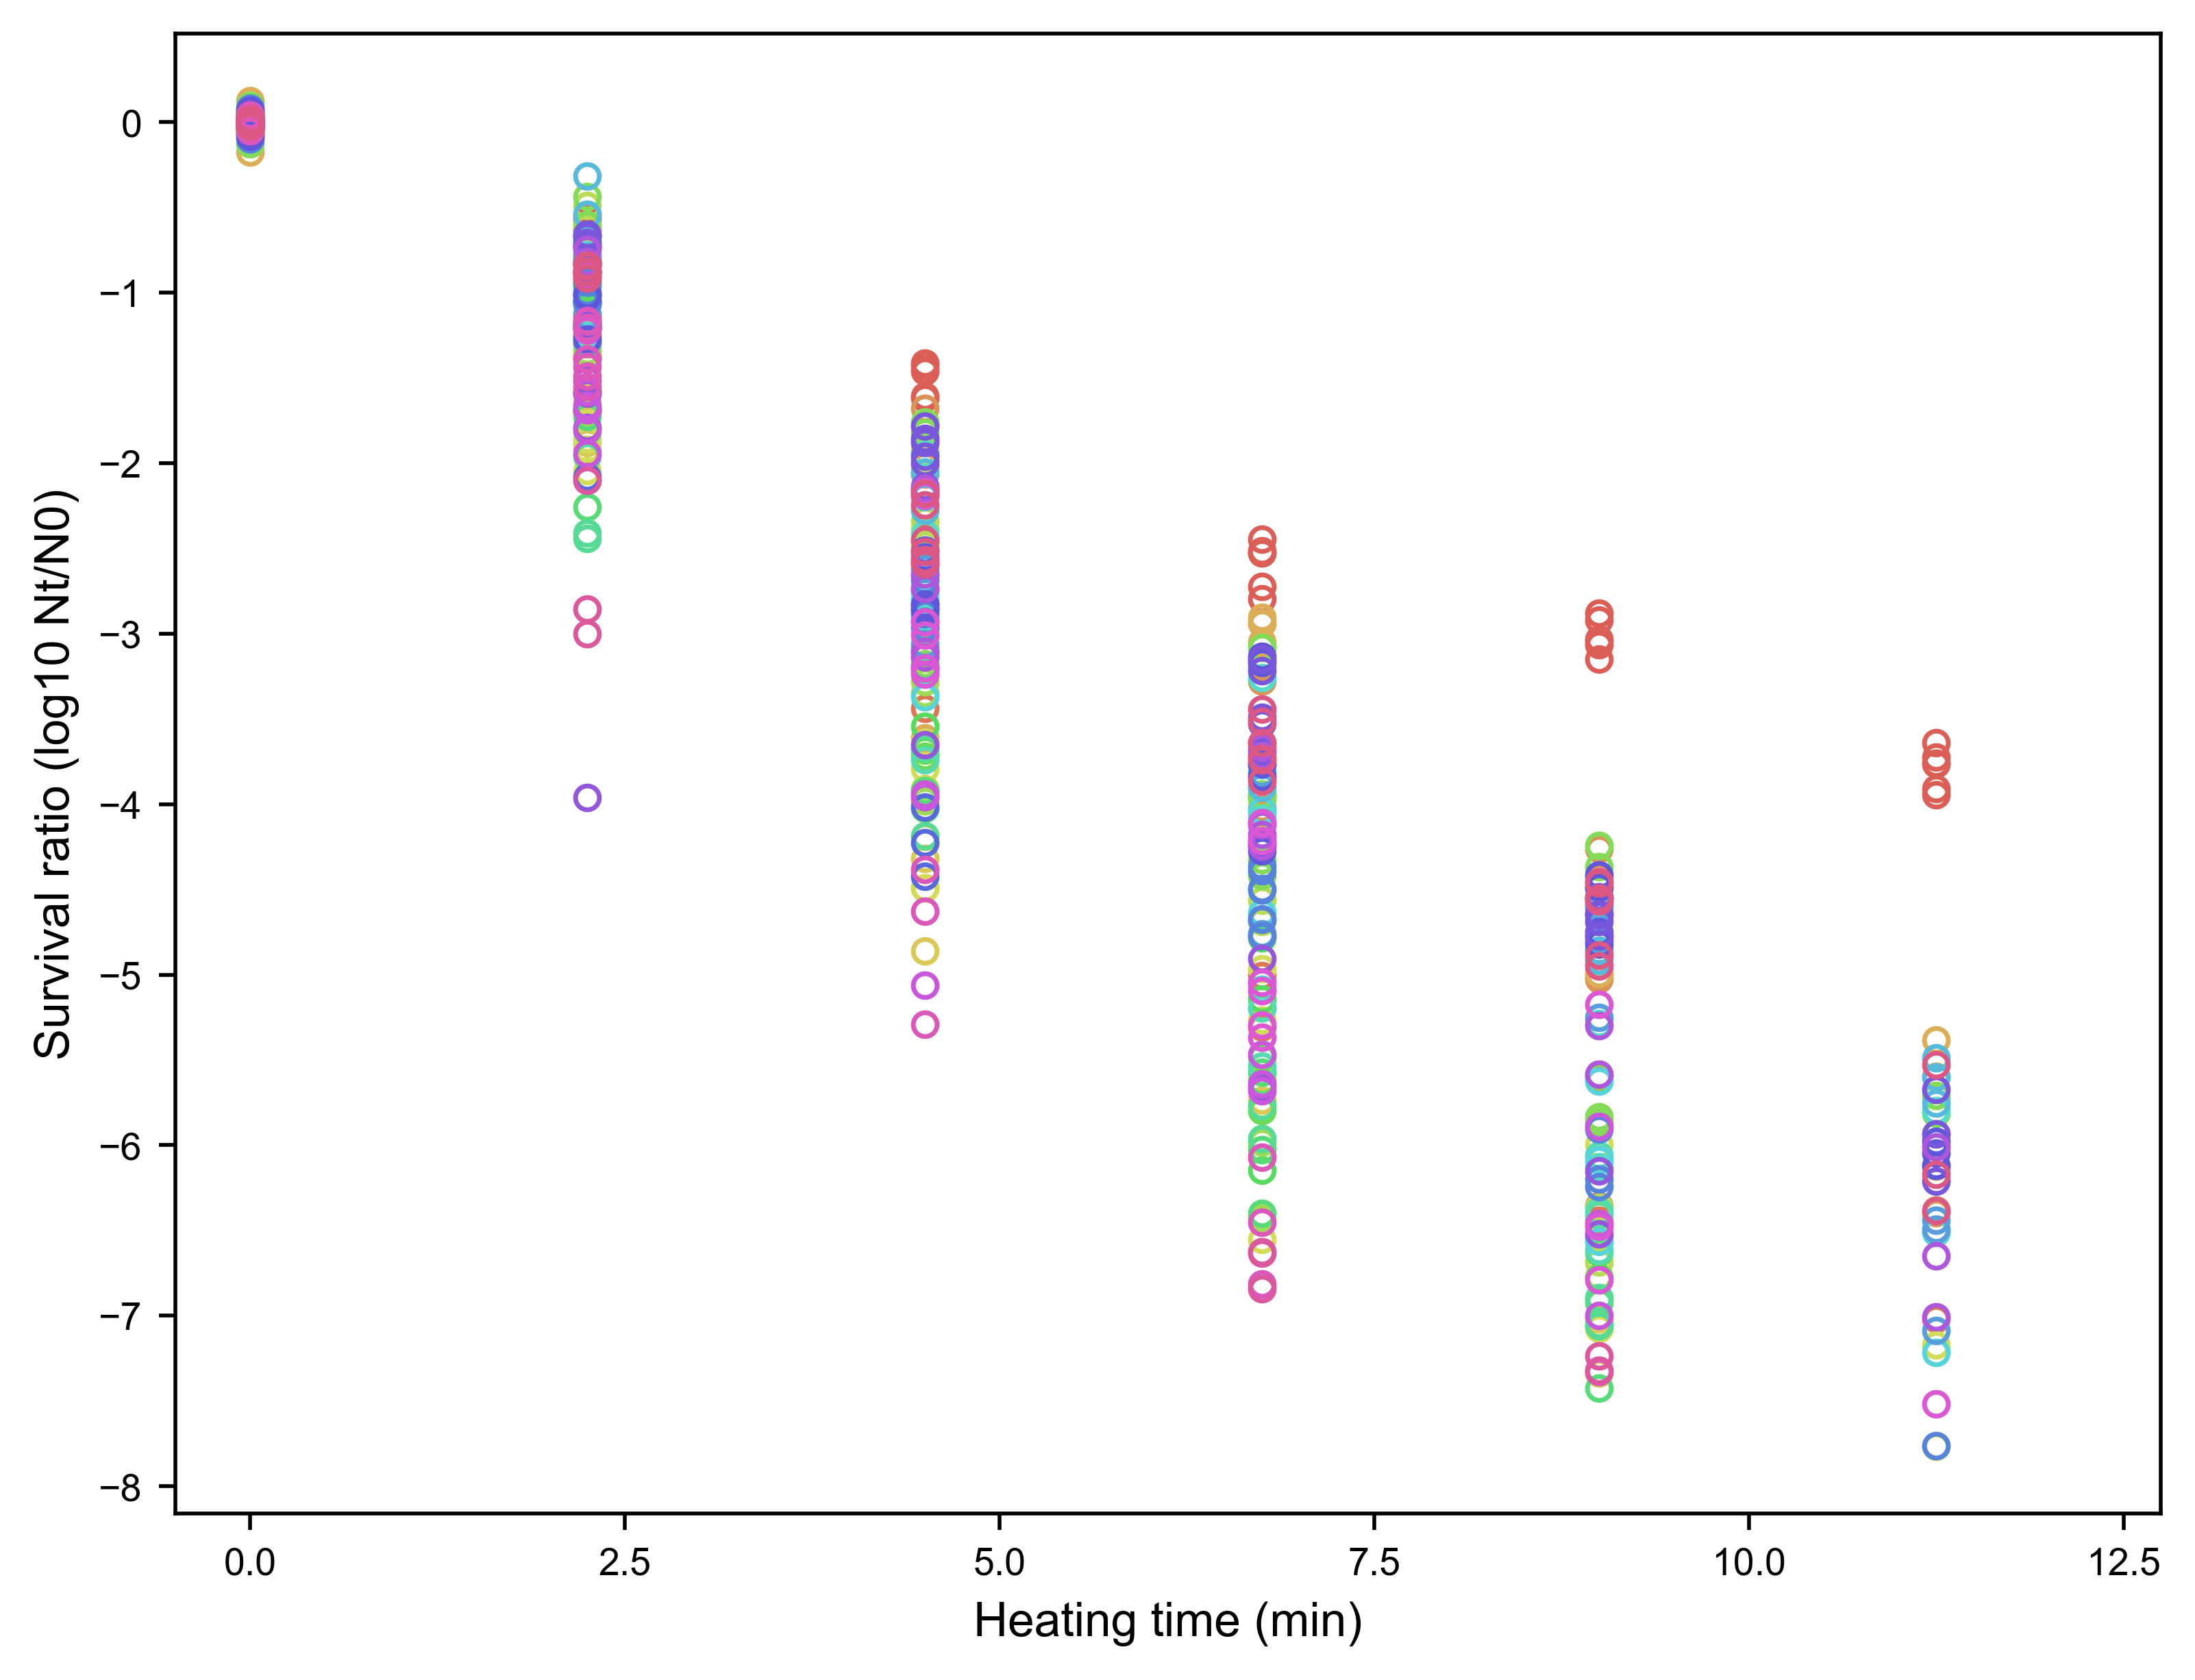

In [13]:
plt.figure(figsize=(19*0.393701,19*0.393701*9/12), dpi=500)
for l in range(StrainCount):
    plt.plot(datum[datum['ID_strain'] == l+1]['t_heat'], datum[datum['ID_strain'] == l+1]['LogSt'], 
             color=Palette[l], 
             label=StrainName[l], 
             linewidth=0,
             marker="o",
             markersize=5,
             markerfacecolor="None"
            )
    

plt.xticks([0,2.5,5.0,7.5,10,12.5], size=8)
plt.yticks(size=8)
plt.xlabel("Heating time (min)",size=10,fontname="Arial")
plt.ylabel("Survival ratio (log10 Nt/N0)",size=10,fontname="Arial")
plt.xlim(-0.5,12.75)
plt.savefig("Figures/Fig. 1.pdf", bbox_inches="tight", dpi=500)
plt.show()

In [ ]:
plt.figure(figsize=(19*0.393701,19*0.393701*9/12), dpi=500)
for l in range(StrainCount):
    plt.plot(datum[datum['ID_strain'] == l+1]['t_heat'], datum[datum['ID_strain'] == l+1]['LogSt'], 
             color=Palette[l], 
             label=StrainName[l], 
             linewidth=0,
             marker="o",
             markersize=5,
             markerfacecolor="None"
            )
    

plt.xticks(size=8)
plt.yticks(size=8)
plt.xlabel("Heating time (min)",size=10,fontname="Arial")
plt.ylabel("Survival ratio (log10 Nt/N0)",size=10,fontname="Arial")
plt.legend(borderpad=0.5, labelspacing=0.1, columnspacing=0.5, handletextpad=0.1, fontsize=8, ncol=6)
plt.xlim(-50.5,-20.5)
plt.savefig("Figures/Fig. 1legend.pdf", bbox_inches="tight", dpi=500)
plt.show()

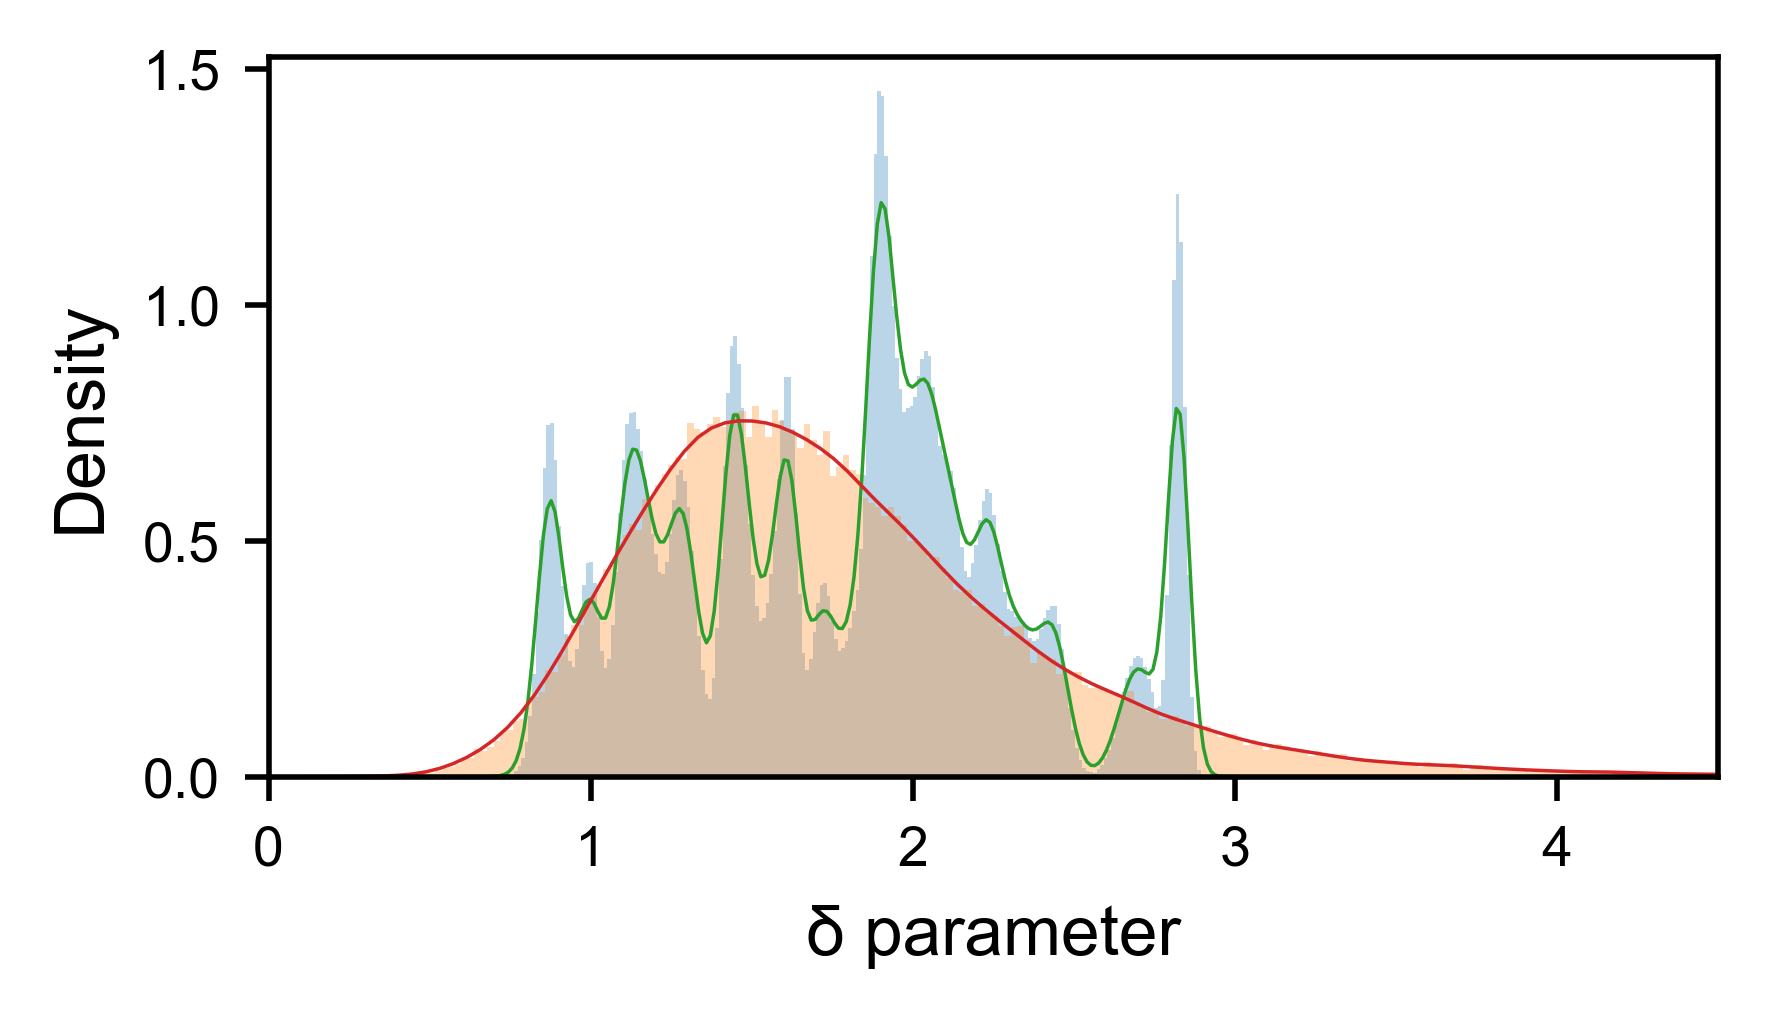

In [15]:
plt.figure(figsize=(9.5*0.393701,9.5*0.393701*7/14), dpi=500)
plt.hist(wholedelta, alpha=0.3, bins=200, density=True)
plt.hist(Paras_sim[:,0], alpha=0.3, bins=400, density=True)
sns.kdeplot(wholedelta, linewidth=0.5)
sns.kdeplot(Paras_sim[:,0], linewidth=0.5)

plt.xticks(size=8)
plt.yticks(size=8)
plt.xlabel("δ parameter",size=10,fontname="Arial")
plt.ylabel("Density",size=10,fontname="Arial")
plt.xlim(0,4.5)
plt.show()

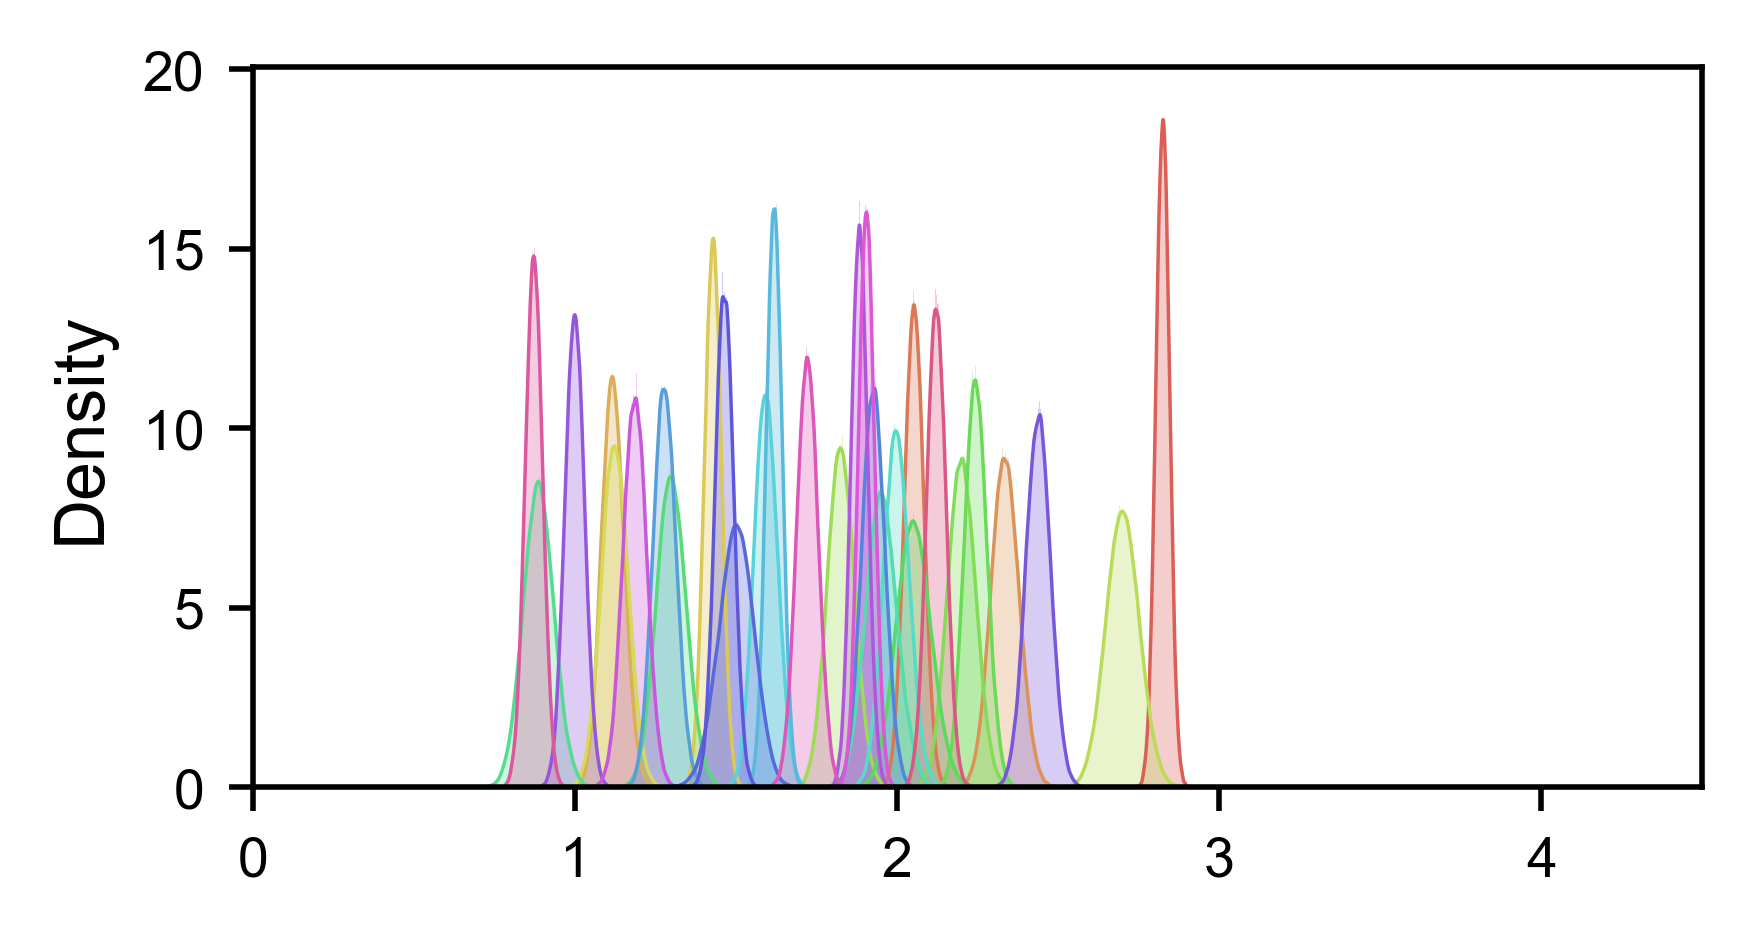

In [16]:
StrainName = list(data["Strain_Name"].unique())
plt.figure(figsize=(9.5*0.393701,9.5*0.393701*7/14), dpi=500)
for i in range(StrainCount):
    plt.hist(samples_onlyMPC['delta'][:,i], alpha=0.3, bins=150, density=True, color=Palette[i])
    sns.kdeplot(samples_onlyMPC['delta'][:,i], color=Palette[i], label=StrainName[i], linewidth=0.5)
plt.xticks(size=8)
plt.yticks(size=8)
plt.xlim(0,4.5)
plt.ylabel("Density",size=10,fontname="Arial")
plt.savefig("Figures/Fig. 4a.pdf", bbox_inches="tight", dpi=500)
plt.show()

In [ ]:
StrainName = list(data["Strain_Name"].unique())
plt.figure(figsize=(19*0.393701,19*0.393701*7/14), dpi=500)
for i in range(StrainCount):
    plt.hist(samples_onlyMPC['delta'][:,i], alpha=0.3, bins=150, density=True, color=Palette[i])
    sns.kdeplot(samples_onlyMPC['delta'][:,i], color=Palette[i], label=StrainName[i], linewidth=0.5)
plt.xticks(size=8)
plt.yticks(size=8)
plt.xlim(-50,-10)
plt.legend(borderpad=0.5, labelspacing=0.1, columnspacing=0.5, handletextpad=0.1, fontsize=8, ncol=6)
plt.savefig("Figures/Fig. 4legends.pdf", bbox_inches="tight", dpi=500)
plt.show()

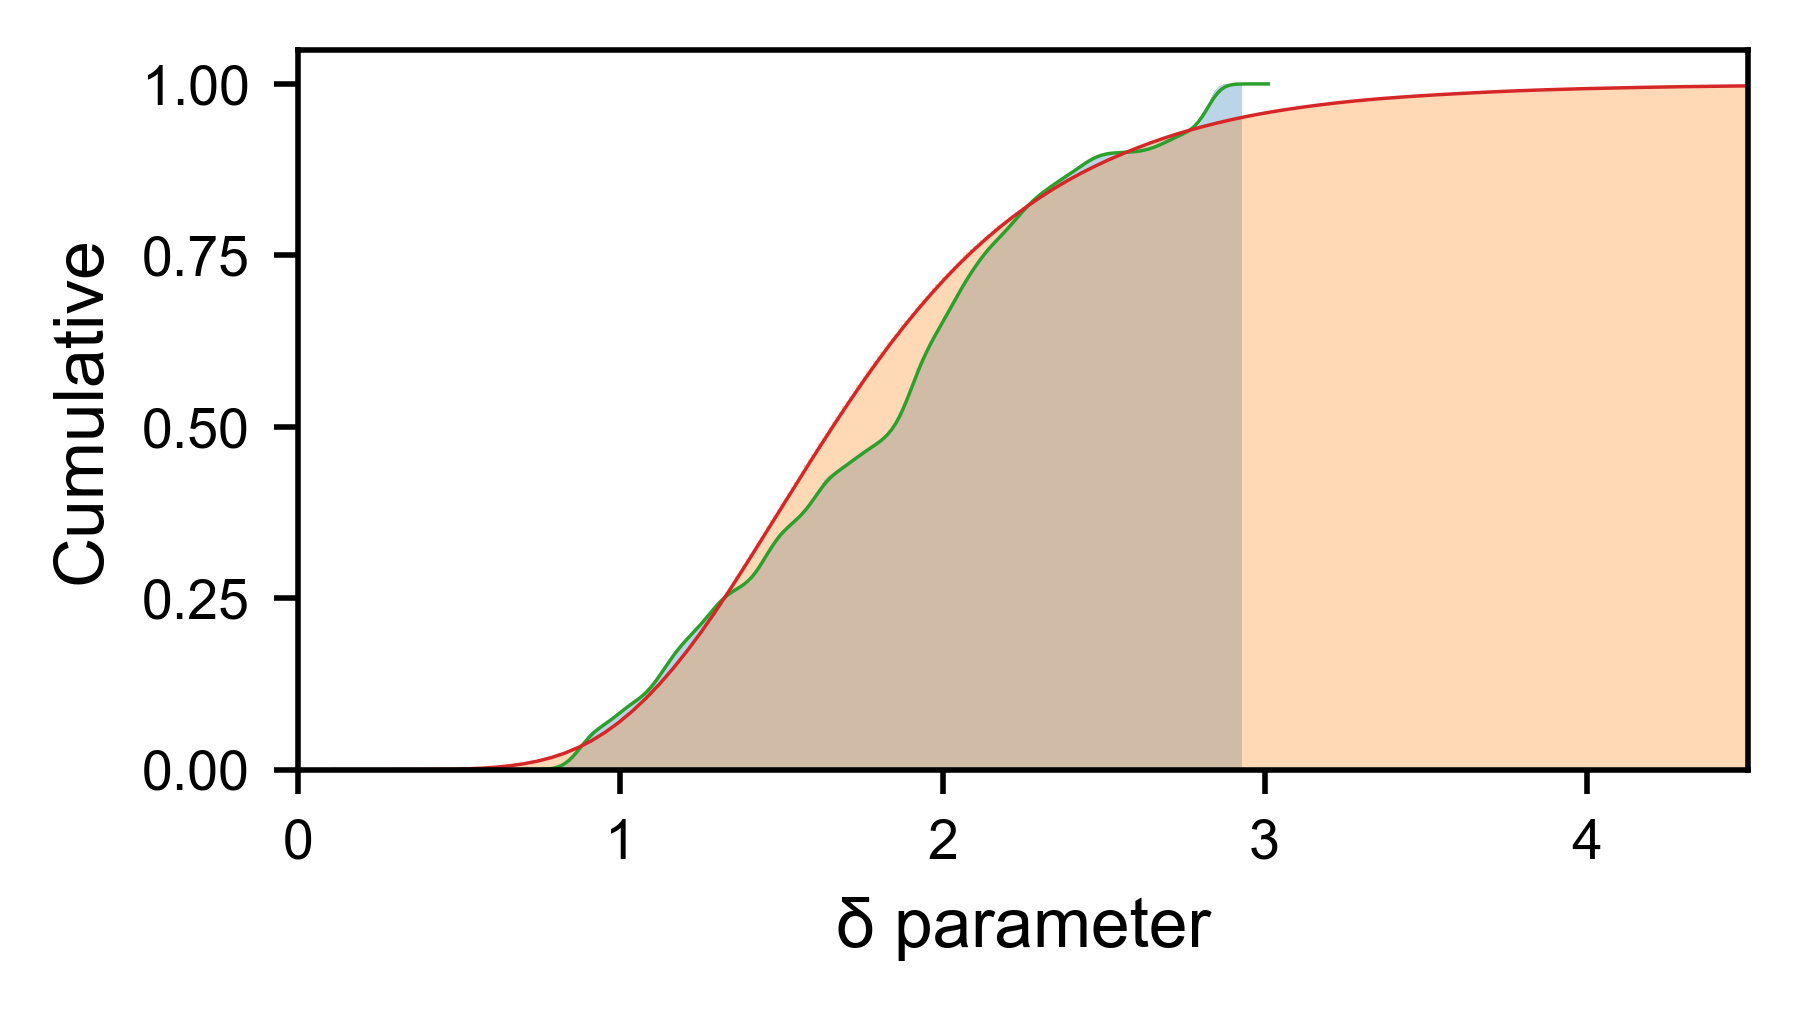

In [18]:
plt.figure(figsize=(9.5*0.393701,9.5*0.393701*7/14), dpi=500)
plt.hist(wholedelta, alpha=0.3, bins=750, density=True, cumulative=True)
plt.hist(Paras_sim[:,0], alpha=0.3, bins=750, density=True, cumulative=True)
sns.kdeplot(wholedelta, cumulative=True, linewidth=0.5)
sns.kdeplot(Paras_sim[:,0], cumulative=True, linewidth=0.5)
plt.xticks(size=8)
plt.yticks(size=8)
plt.xlim(0,4.5)
plt.xlabel("δ parameter",size=10,fontname="Arial")
plt.ylabel("Cumulative",size=10,fontname="Arial")
plt.savefig("Figures/Fig. 4c.pdf", bbox_inches="tight", dpi=500)
plt.show()

In [ ]:
plt.figure(figsize=(9.5*0.393701,9.5*0.393701*7/14), dpi=500)
dens_wholedelta, X_delta = np.histogram(wholedelta, range = (0,4), bins = 400, density = True)
dx_delta = X_delta[1]-X_delta[0]
cumu_wholedelta = np.append(0, np.cumsum(dens_wholedelta)*dx_delta)
dens_preddelta, X_delta2 = np.histogram(Paras_sim[:,0], range = (0,40), bins = 4000, density = True)
dx_delta = X_delta2[1]-X_delta2[0]
cumu_preddelta = np.append(0, np.cumsum(dens_preddelta)*dx_delta)
cumu_preddelta = cumu_preddelta[:len(cumu_wholedelta)]
plt.plot(X_delta, ((cumu_wholedelta-cumu_preddelta)**2)**0.5, linewidth=0.5)
print(np.mean(((cumu_wholedelta-cumu_preddelta)**2)**0.5))
plt.xticks(size=8)
plt.yticks(size=8)
plt.xlabel("δ parameter",size=10,fontname="Arial")
plt.ylabel("Root square error",size=10,fontname="Arial")
plt.xlim(0,4.5)

In [20]:
print(np.quantile(wholedelta,[0.025,0.975]), np.quantile(Paras_sim[:,0],[0.025,0.975]))

[0.86615764 2.83139143] [0.84391566 3.27286752]


In [21]:
plt.figure(figsize=(9.5*0.393701,9.5*0.393701*7/14), dpi=500)
plt.hist(wholepower, alpha=0.3, bins=200, density=True)
plt.hist(Paras_sim[:,1], alpha=0.3, bins=400, density=True)
sns.kdeplot(wholepower, linewidth=0.5)
sns.kdeplot(Paras_sim[:,1], linewidth=0.5)
plt.xticks(size=8)
plt.yticks(size=8)
plt.xlim(0,2.5)
plt.xlabel("p parameter",size=10,fontname="Arial")
plt.ylabel("Density",size=10,fontname="Arial")
plt.show()

In [71]:
plt.figure(figsize=(9.5*0.393701,9.5*0.393701*7/14), dpi=500)
plt.hist(wholepower, alpha=0.3, bins=750, density=True, cumulative=True)
plt.hist(Paras_sim[:,1], alpha=0.3, bins=750, density=True, cumulative=True)
sns.kdeplot(wholepower, cumulative=True, linewidth=0.5)
sns.kdeplot(Paras_sim[:,1], cumulative=True, linewidth=0.5)
plt.xticks(size=8)
plt.yticks(size=8)
plt.xlim(0,2.5)
plt.xlabel("p parameter",size=10,fontname="Arial")
plt.ylabel("Cumulative",size=10,fontname="Arial")
plt.savefig("Figures/Fig. 4d.pdf", bbox_inches="tight", dpi=500)
plt.show()

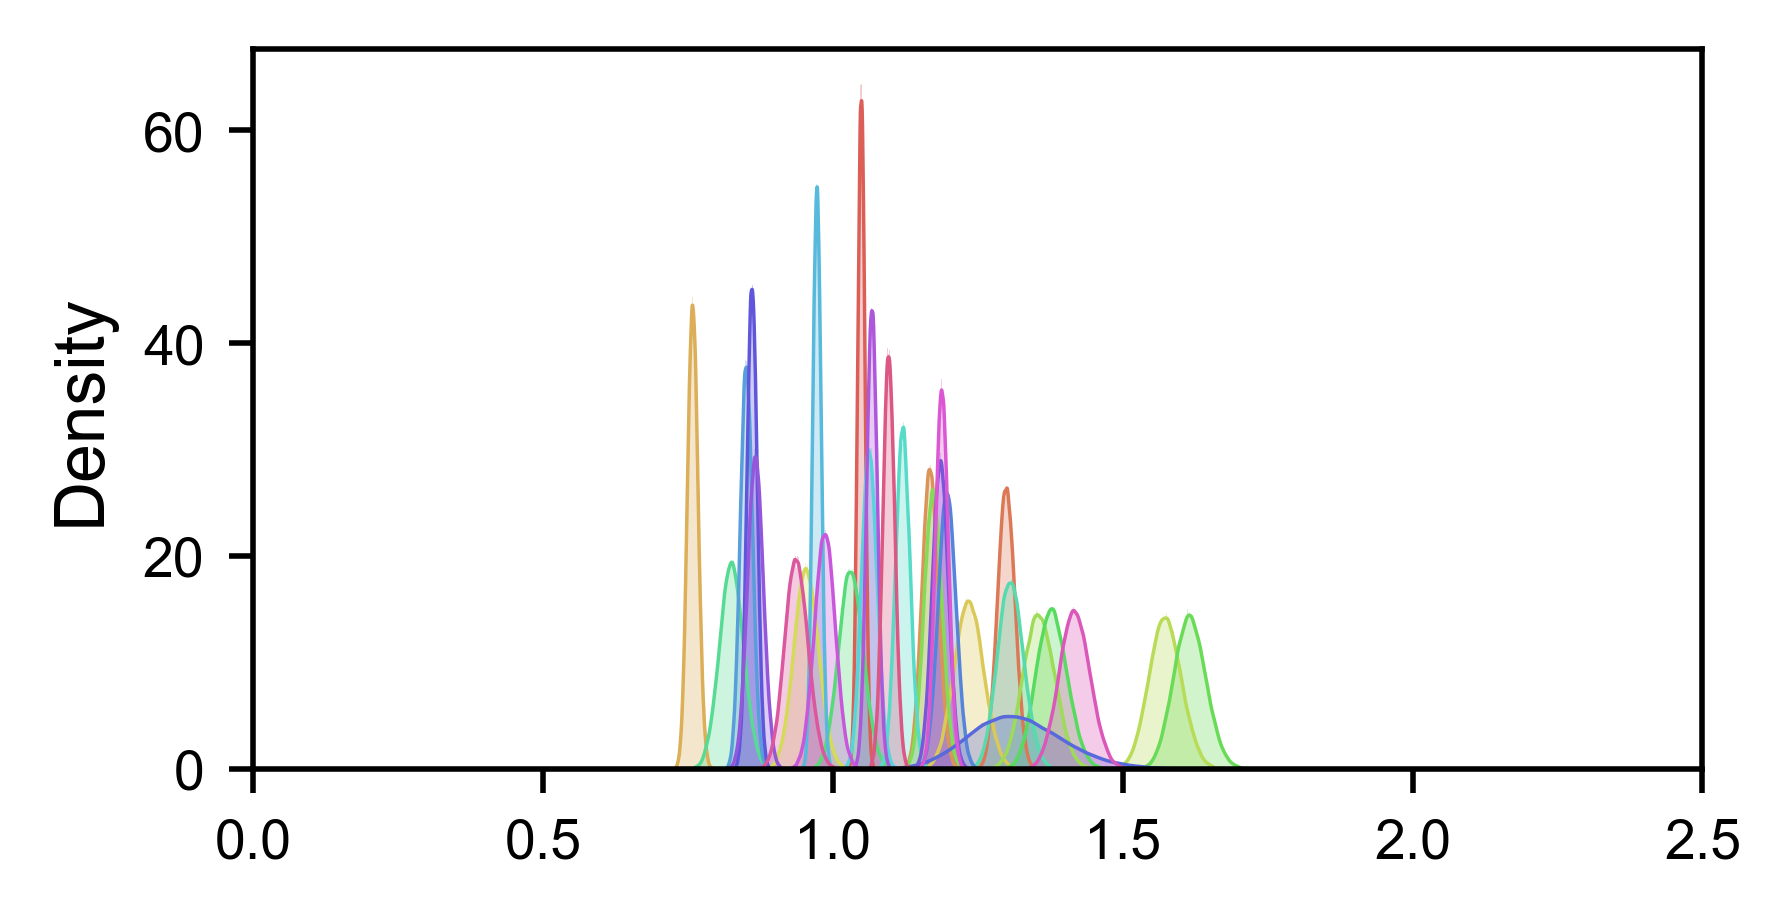

In [23]:
plt.figure(figsize=(9.5*0.393701,9.5*0.393701*7/14), dpi=500)
for i in range(StrainCount):
        plt.hist(samples_onlyMPC['power'][:,i], alpha=0.3, bins=150, density=True, color=Palette[i])
        sns.kdeplot(samples_onlyMPC['power'][:,i], color=Palette[i], label=StrainName[i], linewidth=0.5)
plt.xticks(size=8)
plt.yticks(size=8)
plt.xlim(0,2.5)
plt.ylabel("Density",size=10,fontname="Arial")
plt.savefig("Figures/Fig. 4b.pdf", bbox_inches="tight", dpi=500)
plt.show()

In [ ]:
plt.figure(figsize=(9.5*0.393701,9.5*0.393701*7/14), dpi=500)
dens_wholepower, X_power = np.histogram(wholepower, range = (0,2), bins = 200, density = True)
dx_power = X_power[1]-X_power[0]
cumu_wholepower = np.append(0, np.cumsum(dens_wholepower)*dx_power)
dens_predpower, X_power2 = np.histogram(Paras_sim[:,1], range = (0,20), bins = 2000, density = True)
dx_power = X_power2[1]-X_power2[0]
cumu_predpower = np.append(0, np.cumsum(dens_predpower)*dx_power)
cumu_predpower = cumu_predpower[:len(cumu_wholepower)]
plt.plot(X_power, ((cumu_wholepower-cumu_predpower)**2)**0.5, linewidth=0.5)
plt.xticks(size=8)
plt.yticks(size=8)
plt.xlabel("p parameter",size=10,fontname="Arial")
plt.ylabel("Root square error",size=10,fontname="Arial")
print(np.mean(((cumu_wholepower-cumu_predpower)**2)**0.5))
plt.xlim(0,2.5)
plt.show()

In [25]:
len(cumu_predpower[:len(cumu_wholepower)])

201

In [26]:
print(np.quantile(wholepower,[0.025,0.975]), np.quantile(Paras_sim[:,1],[0.025,0.975]))

[0.76456865 1.60681418] [0.742319   1.67118499]


/opt/anaconda3/envs/pystan/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


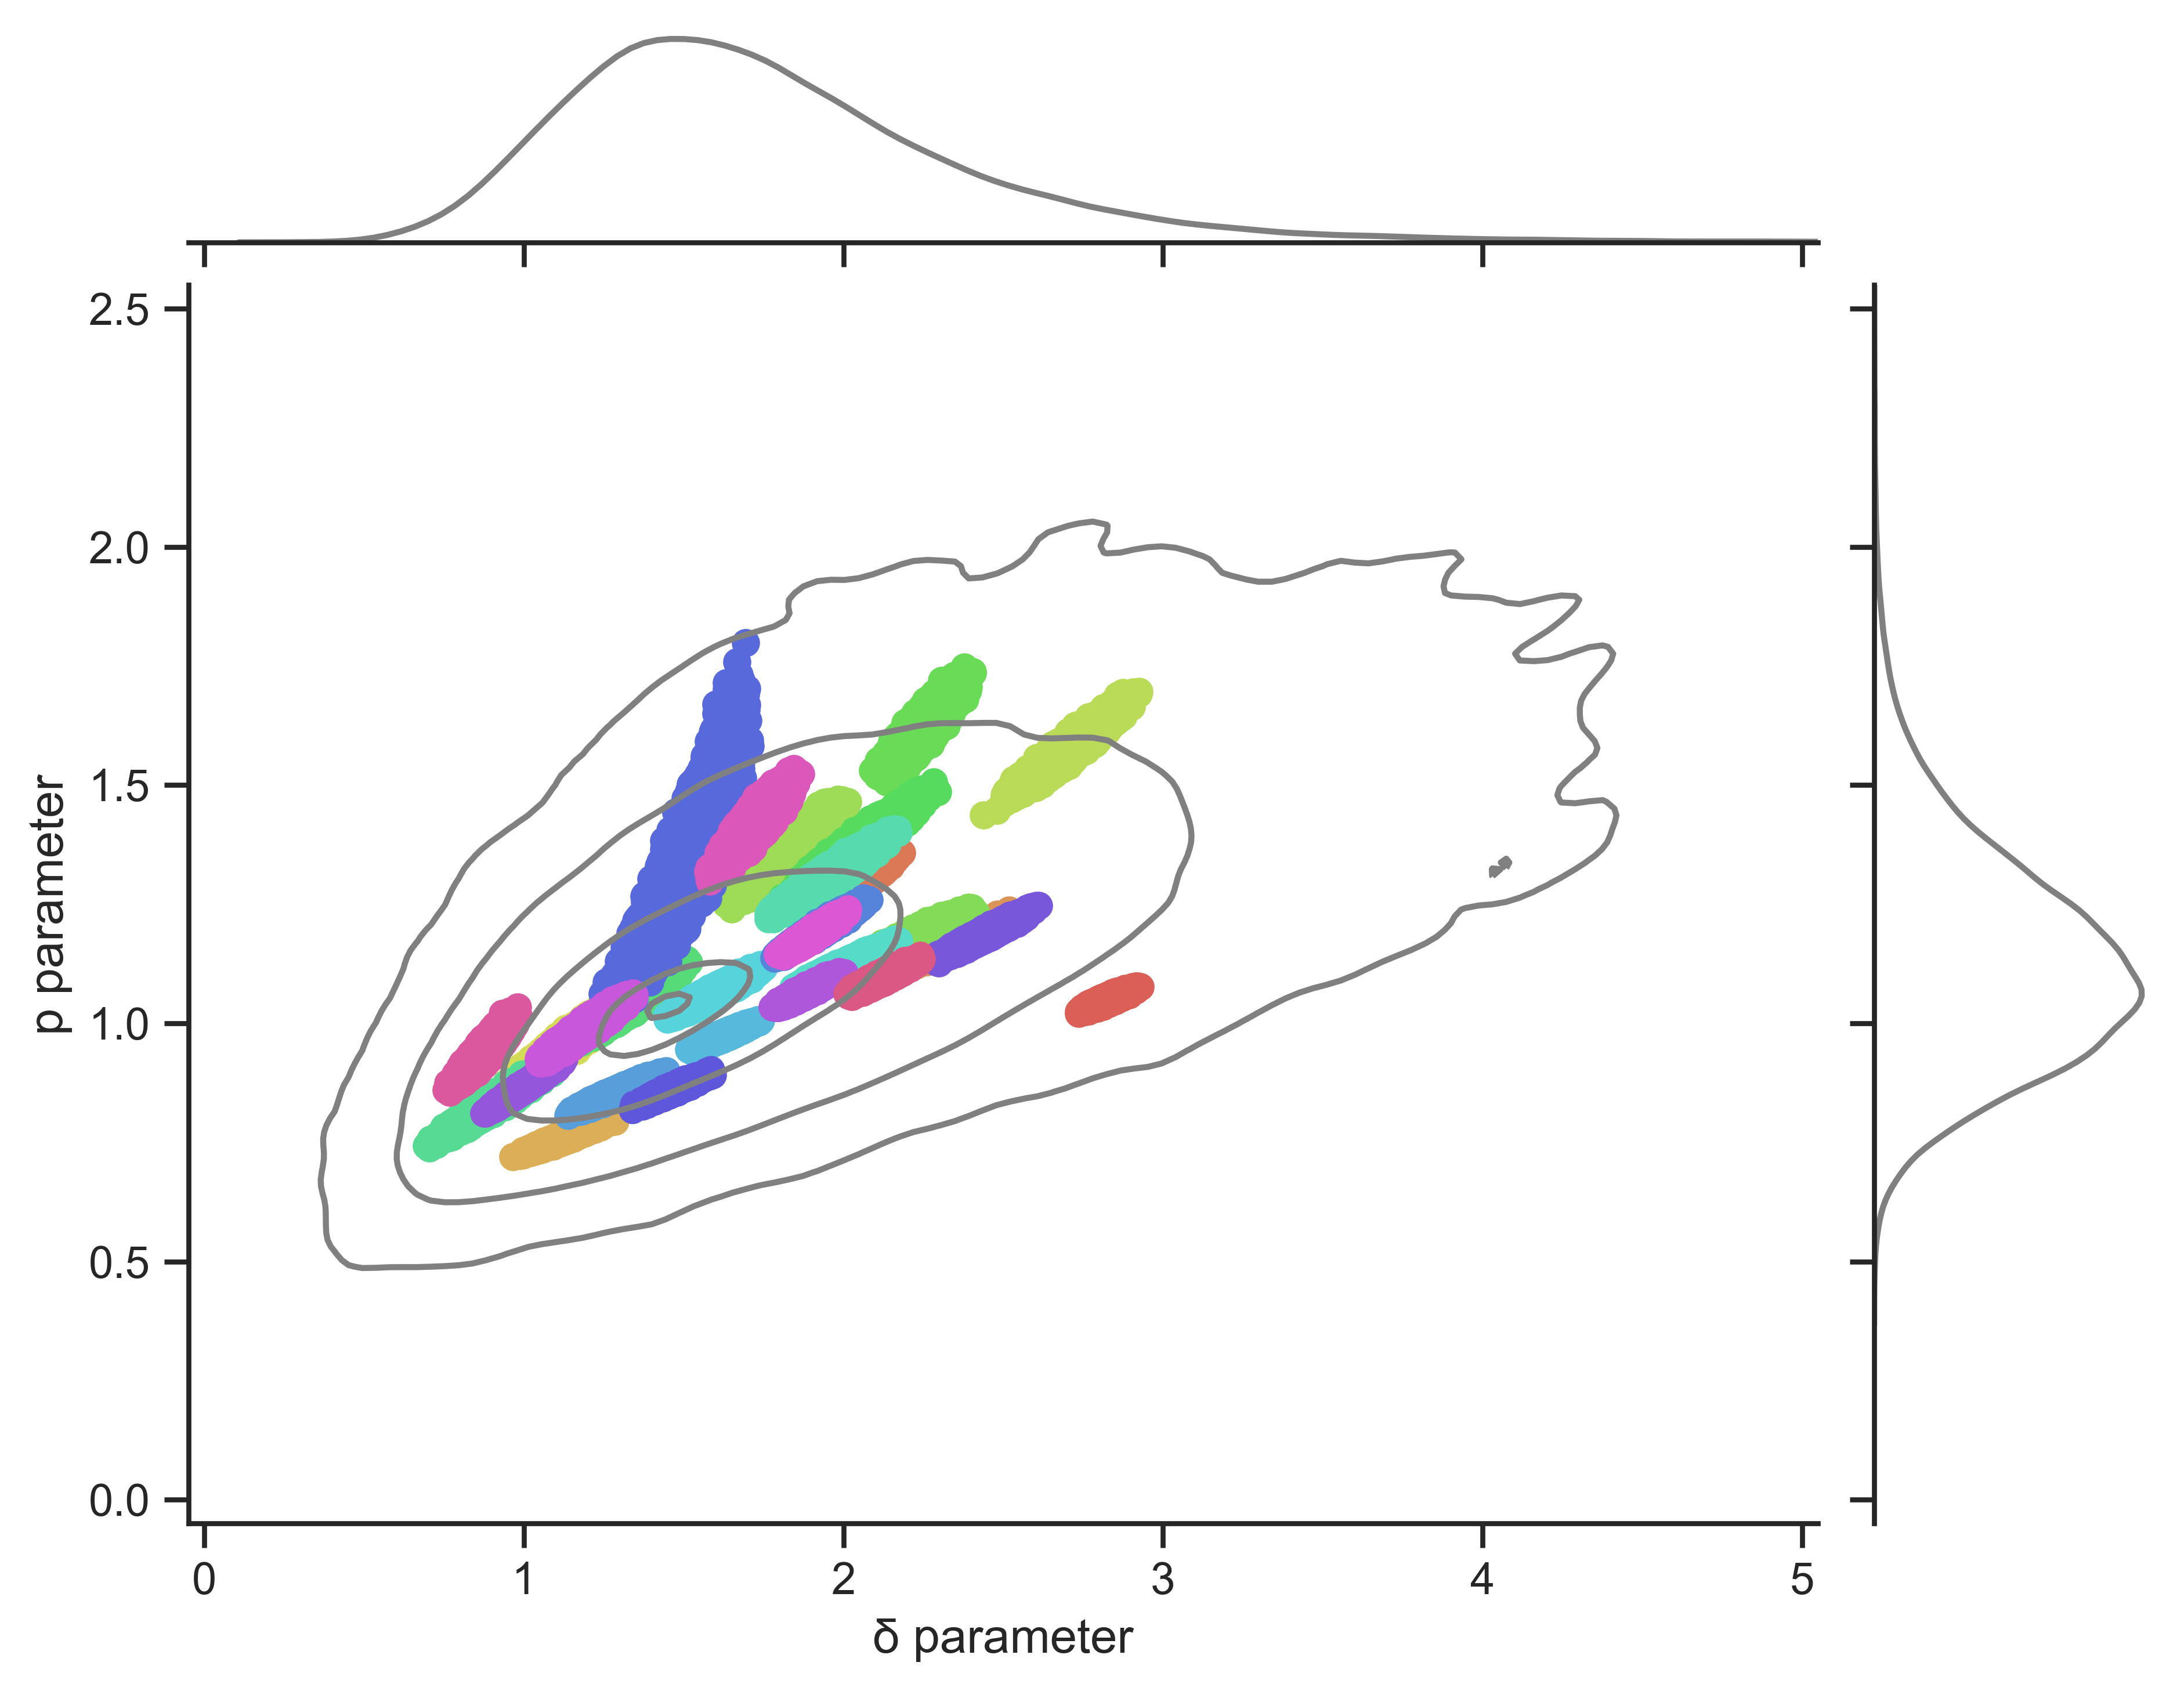

In [27]:
sns.set(rc={'figure.figsize':(9*0.393701,9*0.393701*3/4), "figure.dpi":500, 'savefig.dpi':500})
sns.set_style('ticks')
g = sns.jointplot(Paras_sim[:,0],Paras_sim[:,1], kind="kde", color="gray", levels = [0.01, 0.10, 0.5, 0.90, 0.99])
for i in range(StrainCount):
    g.fig.axes[0].scatter(samples_onlyMPC['delta'][:,i],samples_onlyMPC['power'][:,i], color=Palette[i])
        
g.fig.axes[0].set(xlabel ='δ parameter', ylabel='p parameter', xlim=(-0.05,5.05), ylim=(-0.05,2.55))
g.fig.set_figheight(4.8*1.2)
g.fig.set_figwidth(6.4*1.2)
plt.show()

In [ ]:
sns.set(rc={'figure.figsize':(9*0.393701,9*0.393701*3/4), "figure.dpi":500, 'savefig.dpi':500})
sns.set_style('ticks')
g = sns.jointplot(Paras_sim[:,0],Paras_sim[:,1], kind="kde", color="gray", levels = [0.01, 0.10, 0.5, 0.90, 0.99])
for i in range(StrainCount):
    g.fig.axes[0].scatter(samples_onlyMPC['delta'][:,i],samples_onlyMPC['power'][:,i], color=Palette[i], marker = ".", alpha=0.025)
        
g.fig.axes[0].set(xlabel ='δ parameter', ylabel='p parameter', xlim=(-0.05,5.05), ylim=(-0.05,2.55))
g.fig.set_figheight(4.8*1.2)
g.fig.set_figwidth(6.4*1.2)
plt.savefig("Figures/Fig. 2.pdf", bbox_inches="tight", dpi=500)
plt.show()

/opt/anaconda3/envs/pystan/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


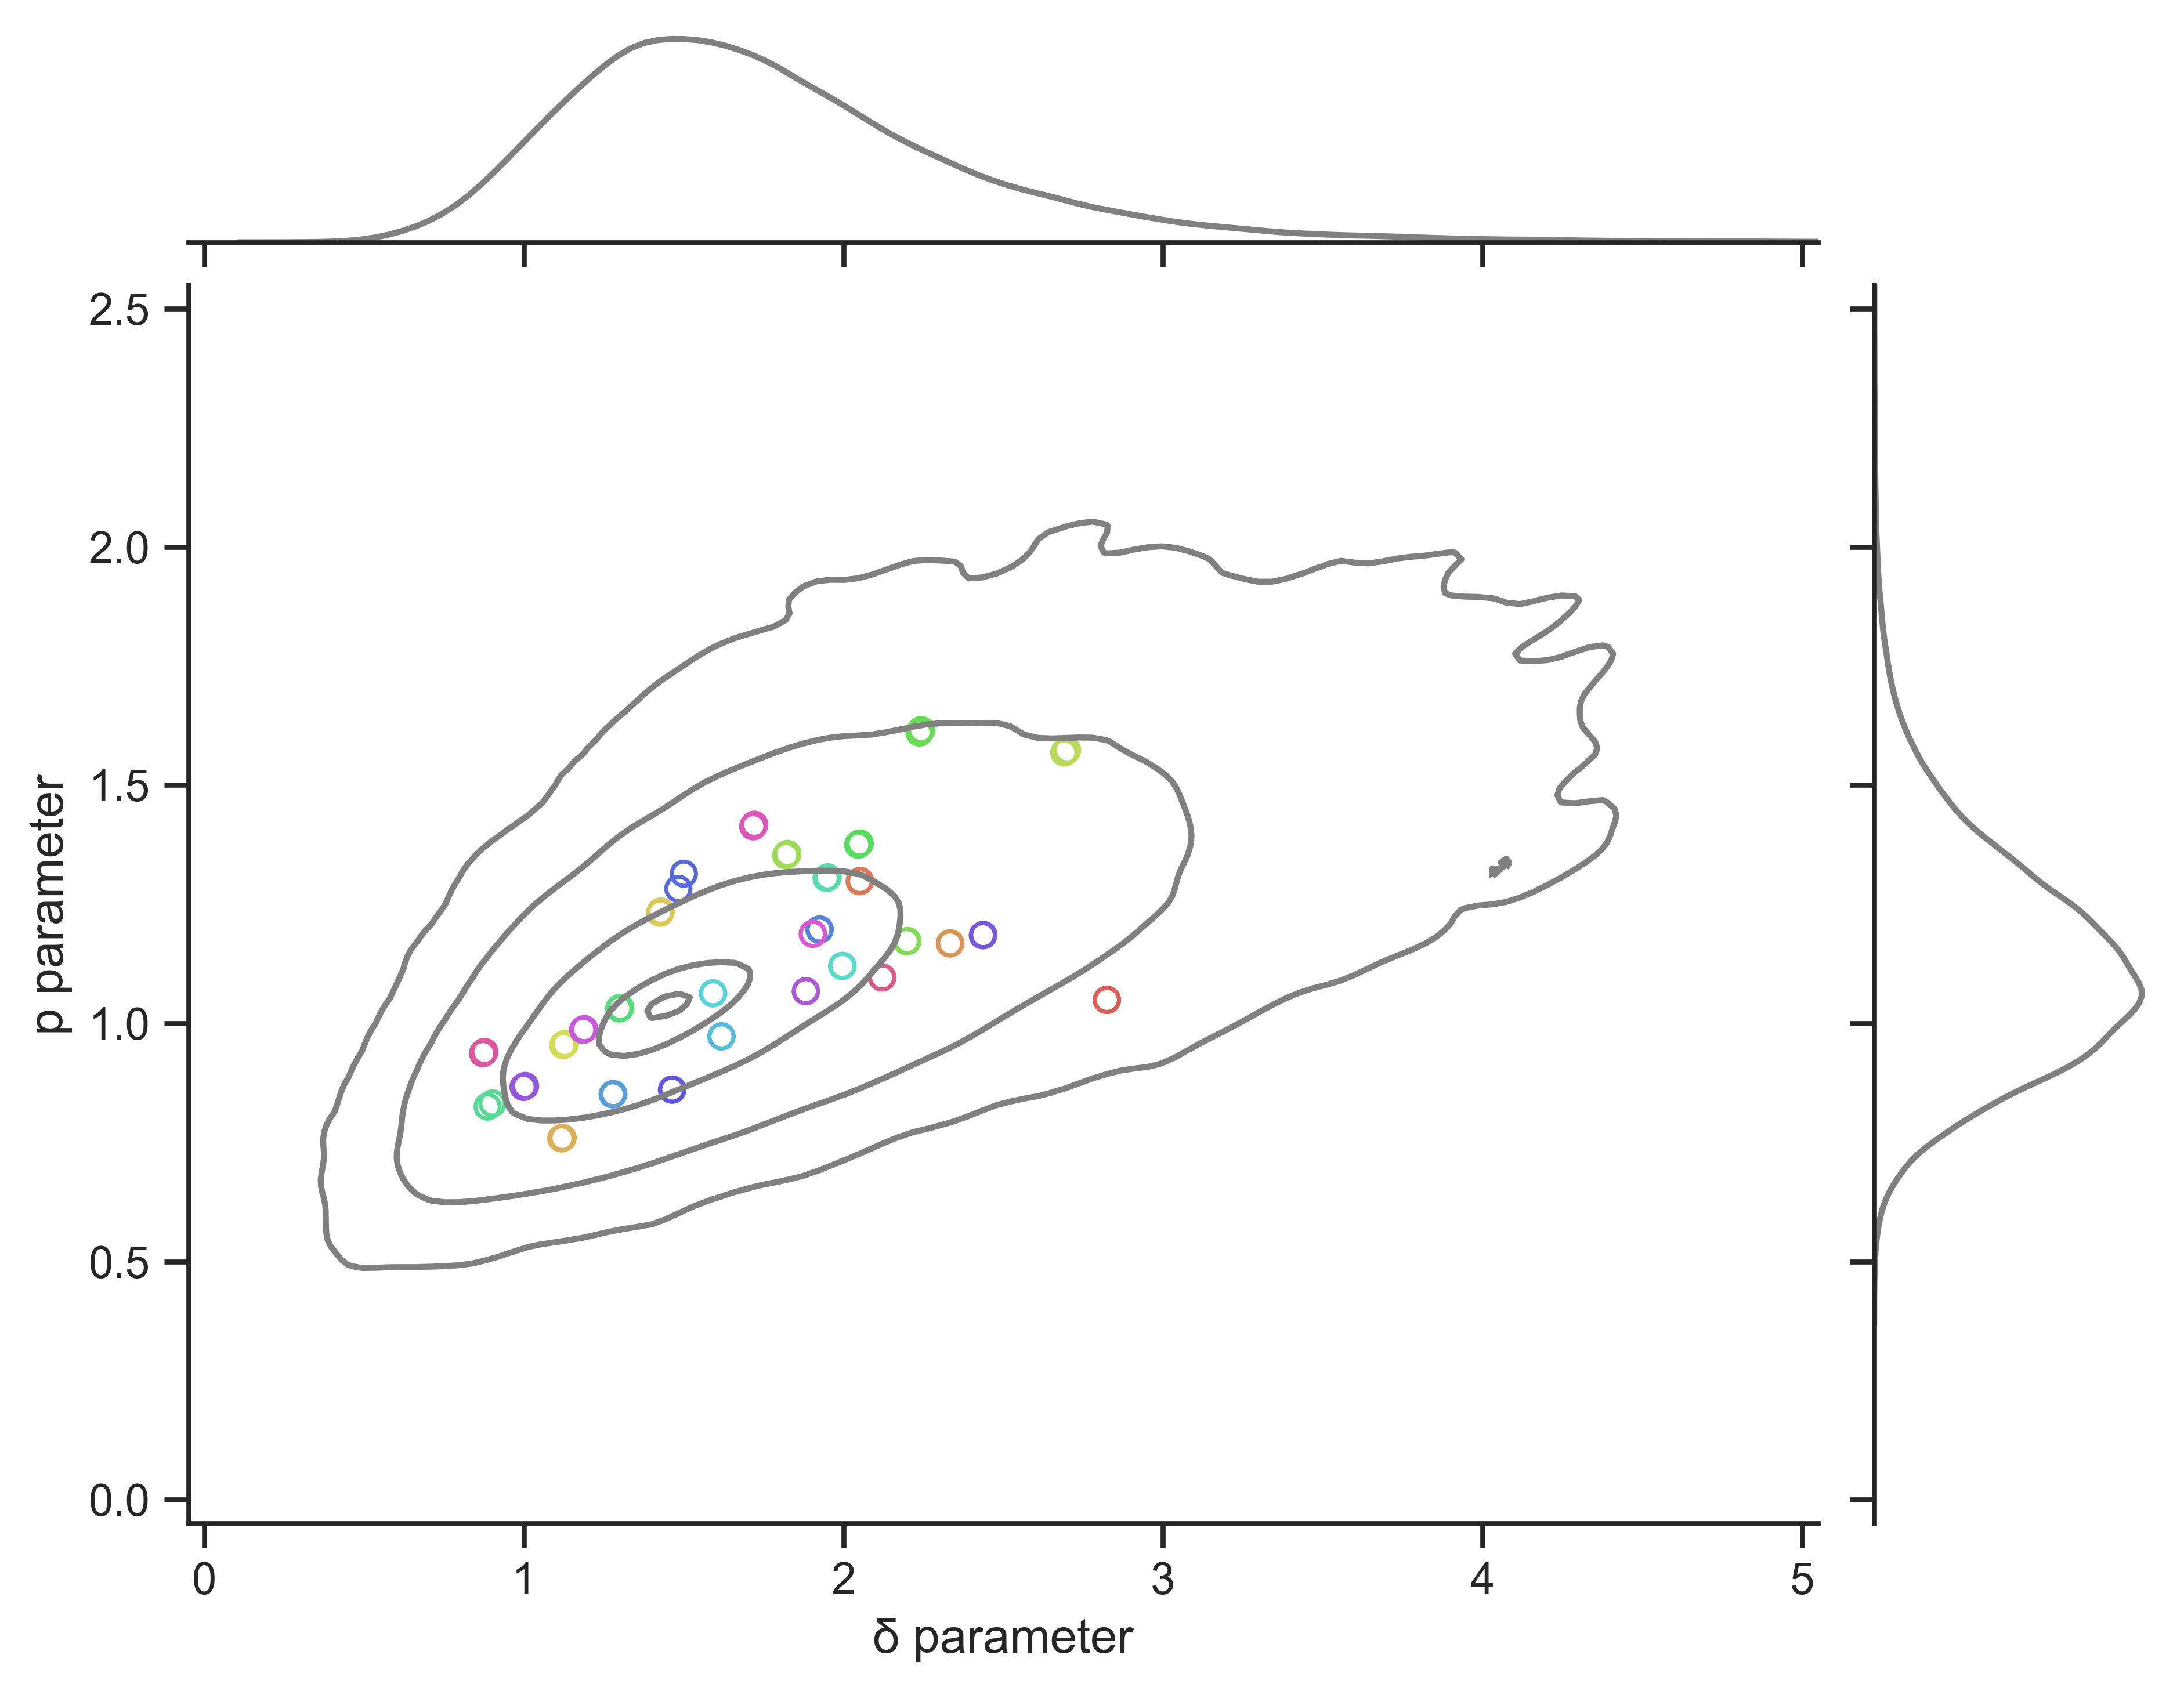

In [29]:
sns.set(rc={'figure.figsize':(9*0.393701,9*0.393701*3/4), "figure.dpi":500, 'savefig.dpi':500})
sns.set_style('ticks')
g = sns.jointplot(Paras_sim[:,0],Paras_sim[:,1], kind="kde", color="gray", levels = [0.01, 0.10, 0.5, 0.90, 0.99])
for i in range(StrainCount):
    g.fig.axes[0].scatter(np.median(samples_onlyMPC['delta'][:,i]),np.median(samples_onlyMPC['power'][:,i]), color=Palette[i], facecolor="None")
    g.fig.axes[0].scatter(np.median(samples_allMVN['delta'][:,i]),np.median(samples_allMVN['power'][:,i]), color=Palette[i], facecolor="None")
        
g.fig.axes[0].set(xlabel ='δ parameter', ylabel='p parameter', xlim=(-0.05,5.05), ylim=(-0.05,2.55))
g.fig.set_figheight(4.8*1.2)
g.fig.set_figwidth(6.4*1.2)
plt.show()

/opt/anaconda3/envs/pystan/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


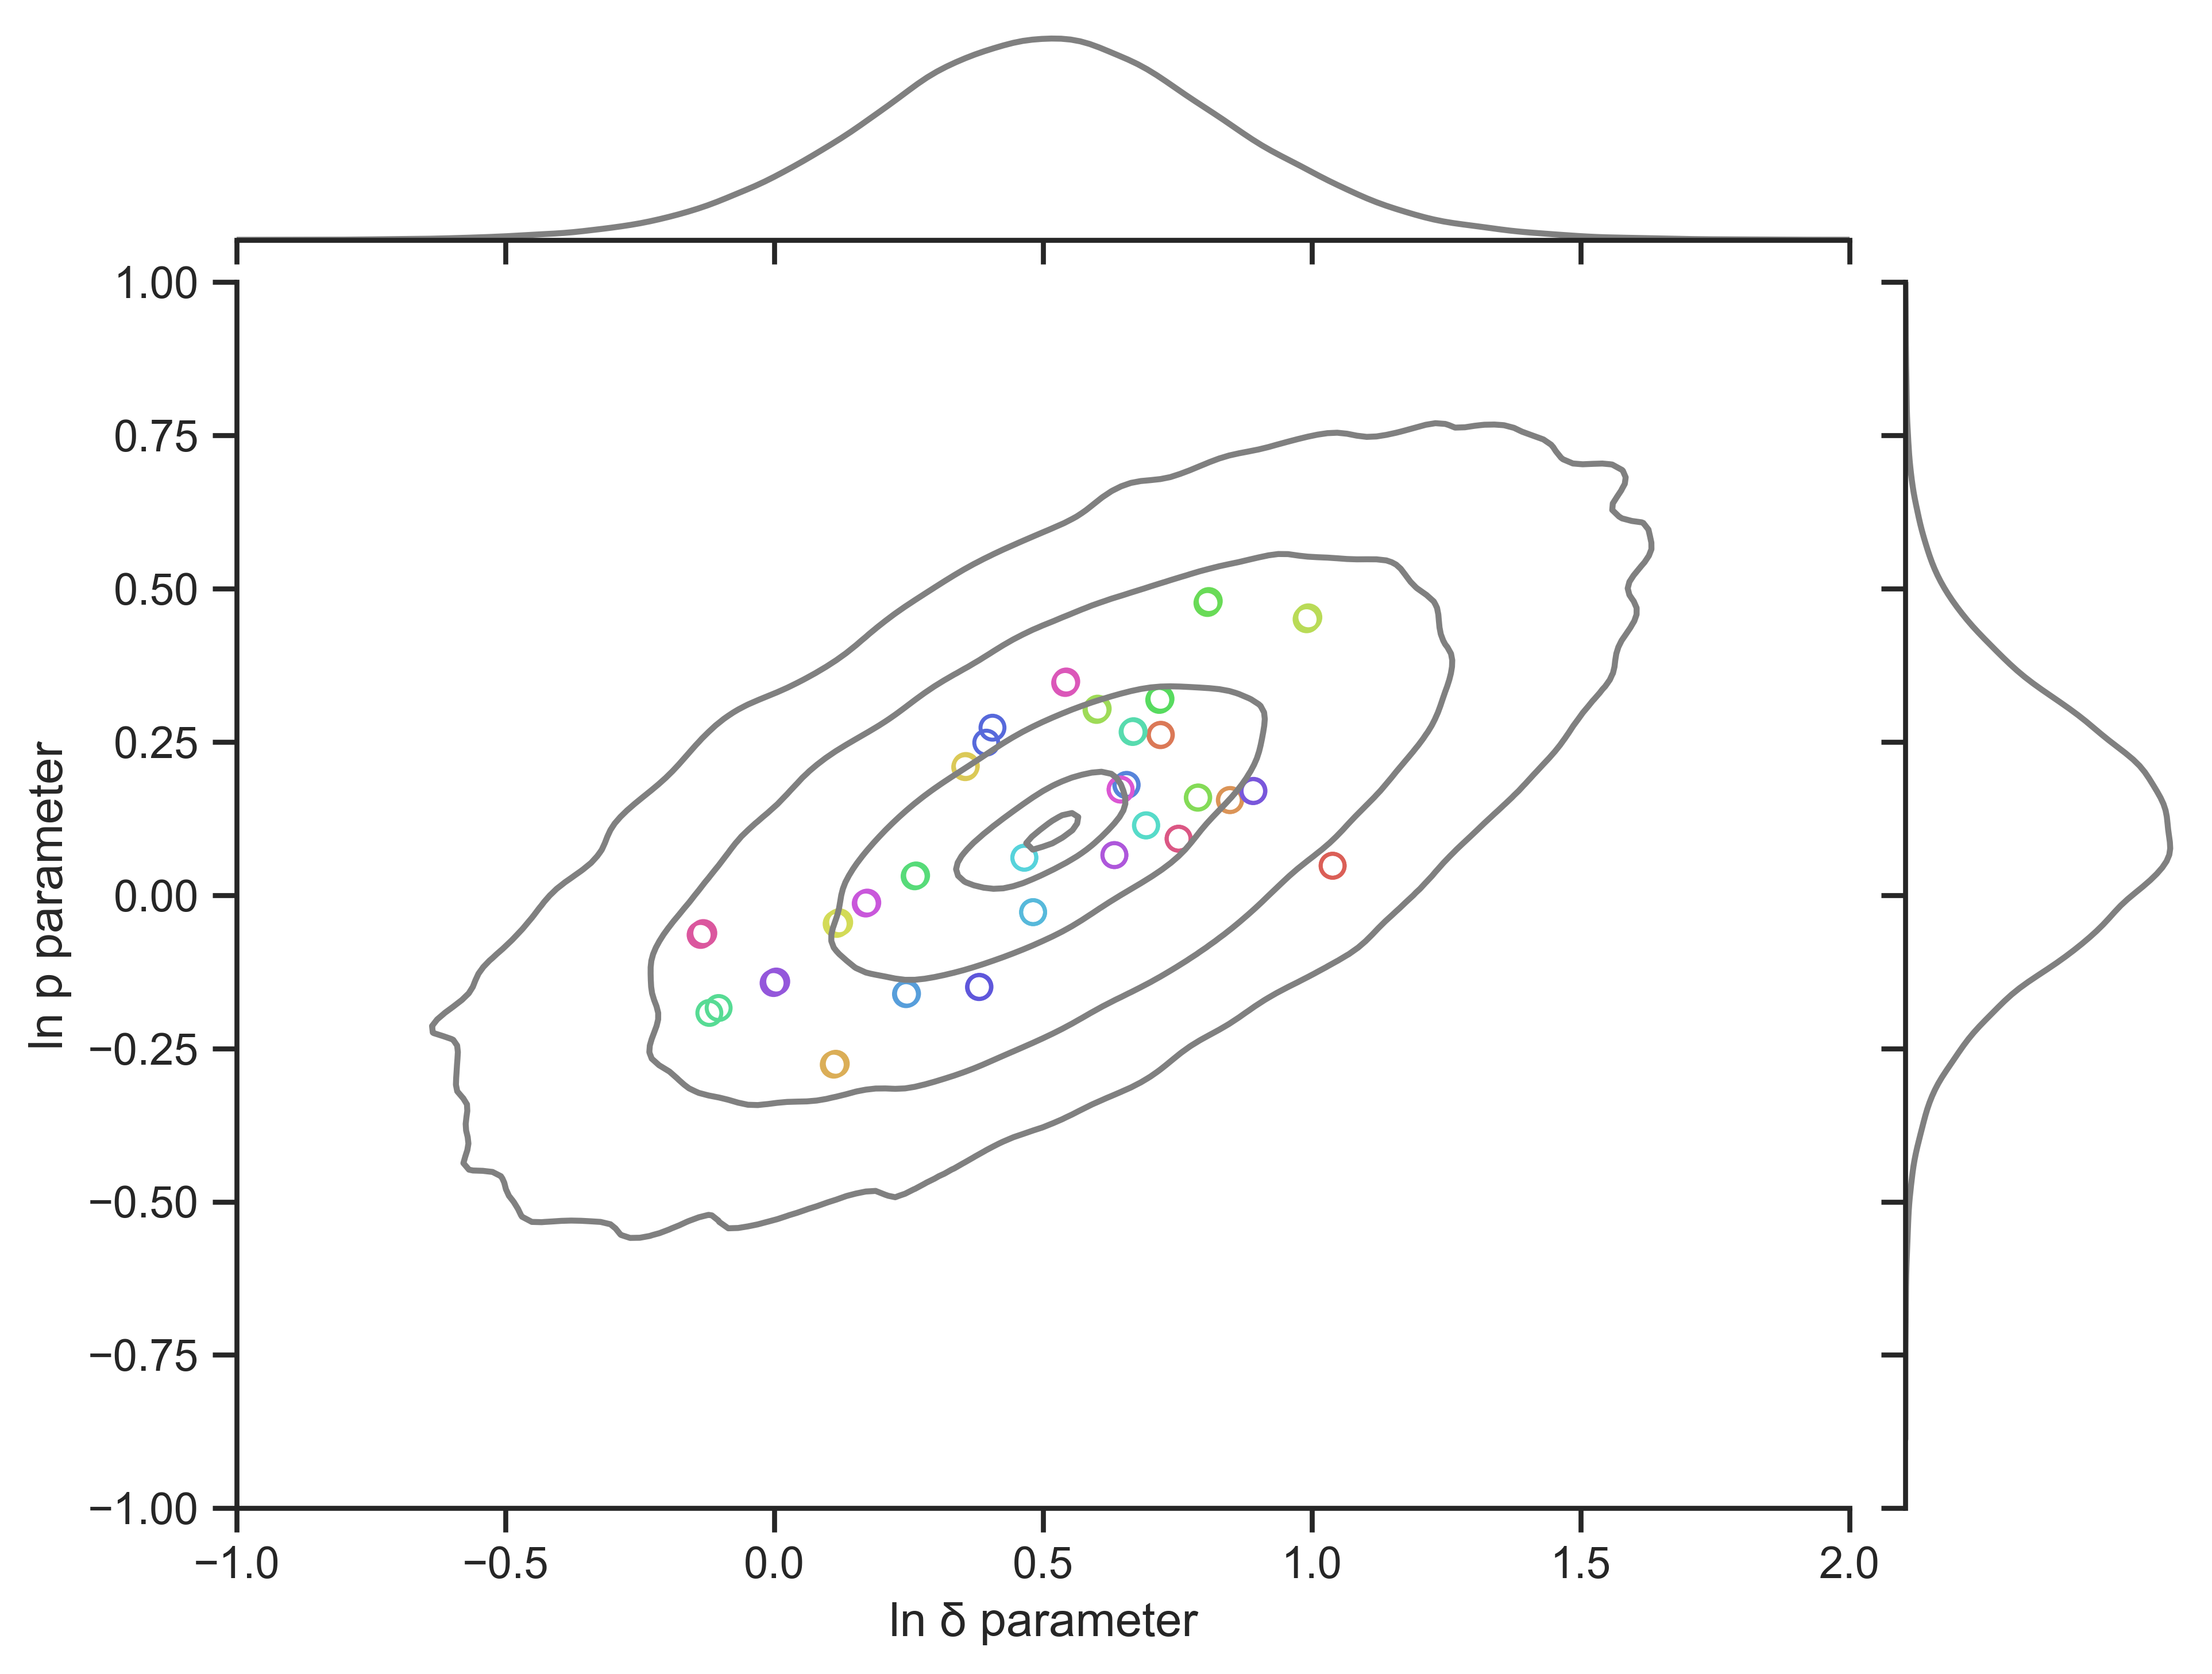

In [30]:
sns.set(rc={'figure.figsize':(9*0.393701,9*0.393701*3/4), "figure.dpi":500, 'savefig.dpi':500})
sns.set_style('ticks')
g = sns.jointplot(logParas_sim[:,0],logParas_sim[:,1], color="gray", kind="kde", levels = [0.01, 0.10, 0.5, 0.90, 0.99])
for i in range(StrainCount):
    g.fig.axes[0].scatter(np.log(np.median(samples_onlyMPC['delta'][:,i])),np.log(np.median(samples_onlyMPC['power'][:,i])), color=Palette[i], facecolor="None")
    g.fig.axes[0].scatter(np.log(np.median(samples_allMVN['delta'][:,i])),np.log(np.median(samples_allMVN['power'][:,i])), color=Palette[i], facecolor="None")
        
g.fig.axes[0].set(xlabel ='ln δ parameter', ylabel='ln p parameter', xlim=(-1,2), ylim=(-1,1))
g.fig.set_figheight(4.8*1.2)
g.fig.set_figwidth(6.4*1.2)
plt.show()

In [31]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["font.family"] = "Arial"

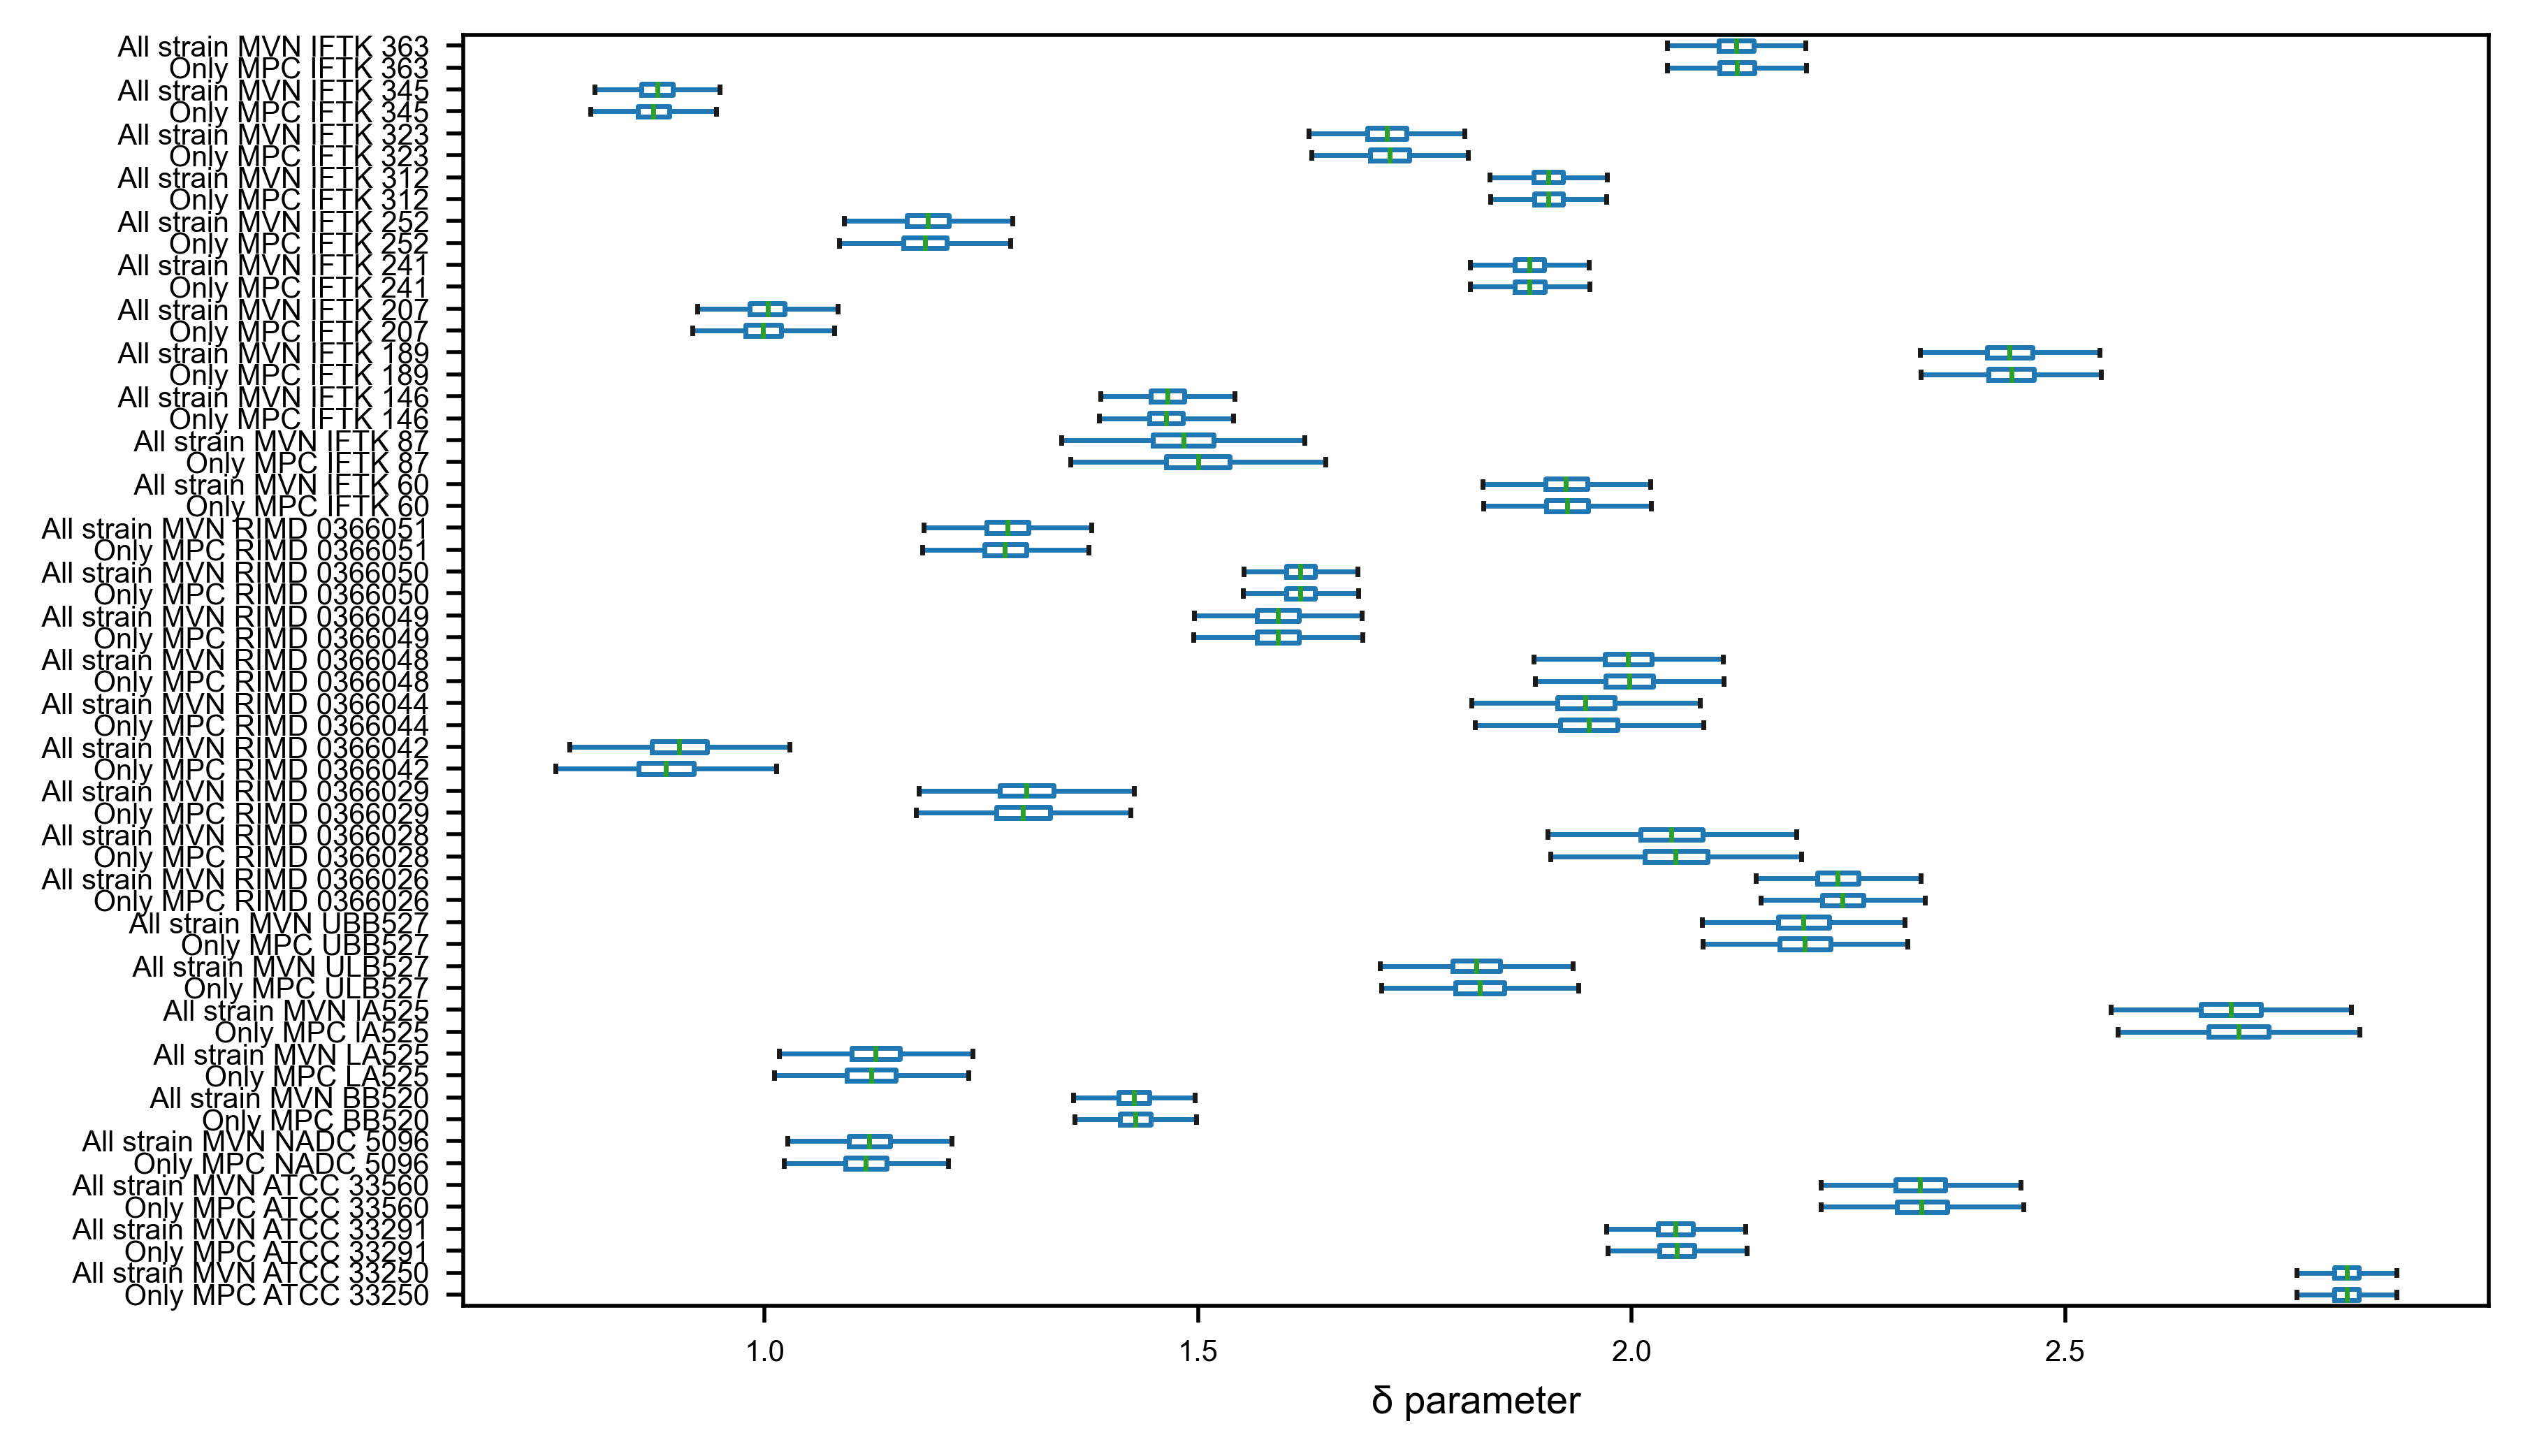

In [32]:
plt.figure(figsize=(19*0.393701,24*0.393701/2), dpi=500)
ComData = pd.DataFrame({" Only MPC "+StrainName[0]:samples_onlyMPC['delta'][:,0]," All strain MVN "+StrainName[0]:samples_allMVN['delta'][:,0]})

for i in range(1,StrainCount):
    ComData[" Only MPC "+StrainName[i]]=samples_onlyMPC['delta'][:,i]
    ComData[" All strain MVN "+StrainName[i]]=samples_allMVN['delta'][:,i]
ComData.boxplot(vert=False,sym = ".", showfliers = False, grid=False)
plt.xticks(size=6)
plt.yticks(size=6)
plt.xlabel("δ parameter",size=8,fontname="Arial")
plt.savefig("Figures/Fig. S2a.pdf", bbox_inches="tight", dpi=500)
plt.show()

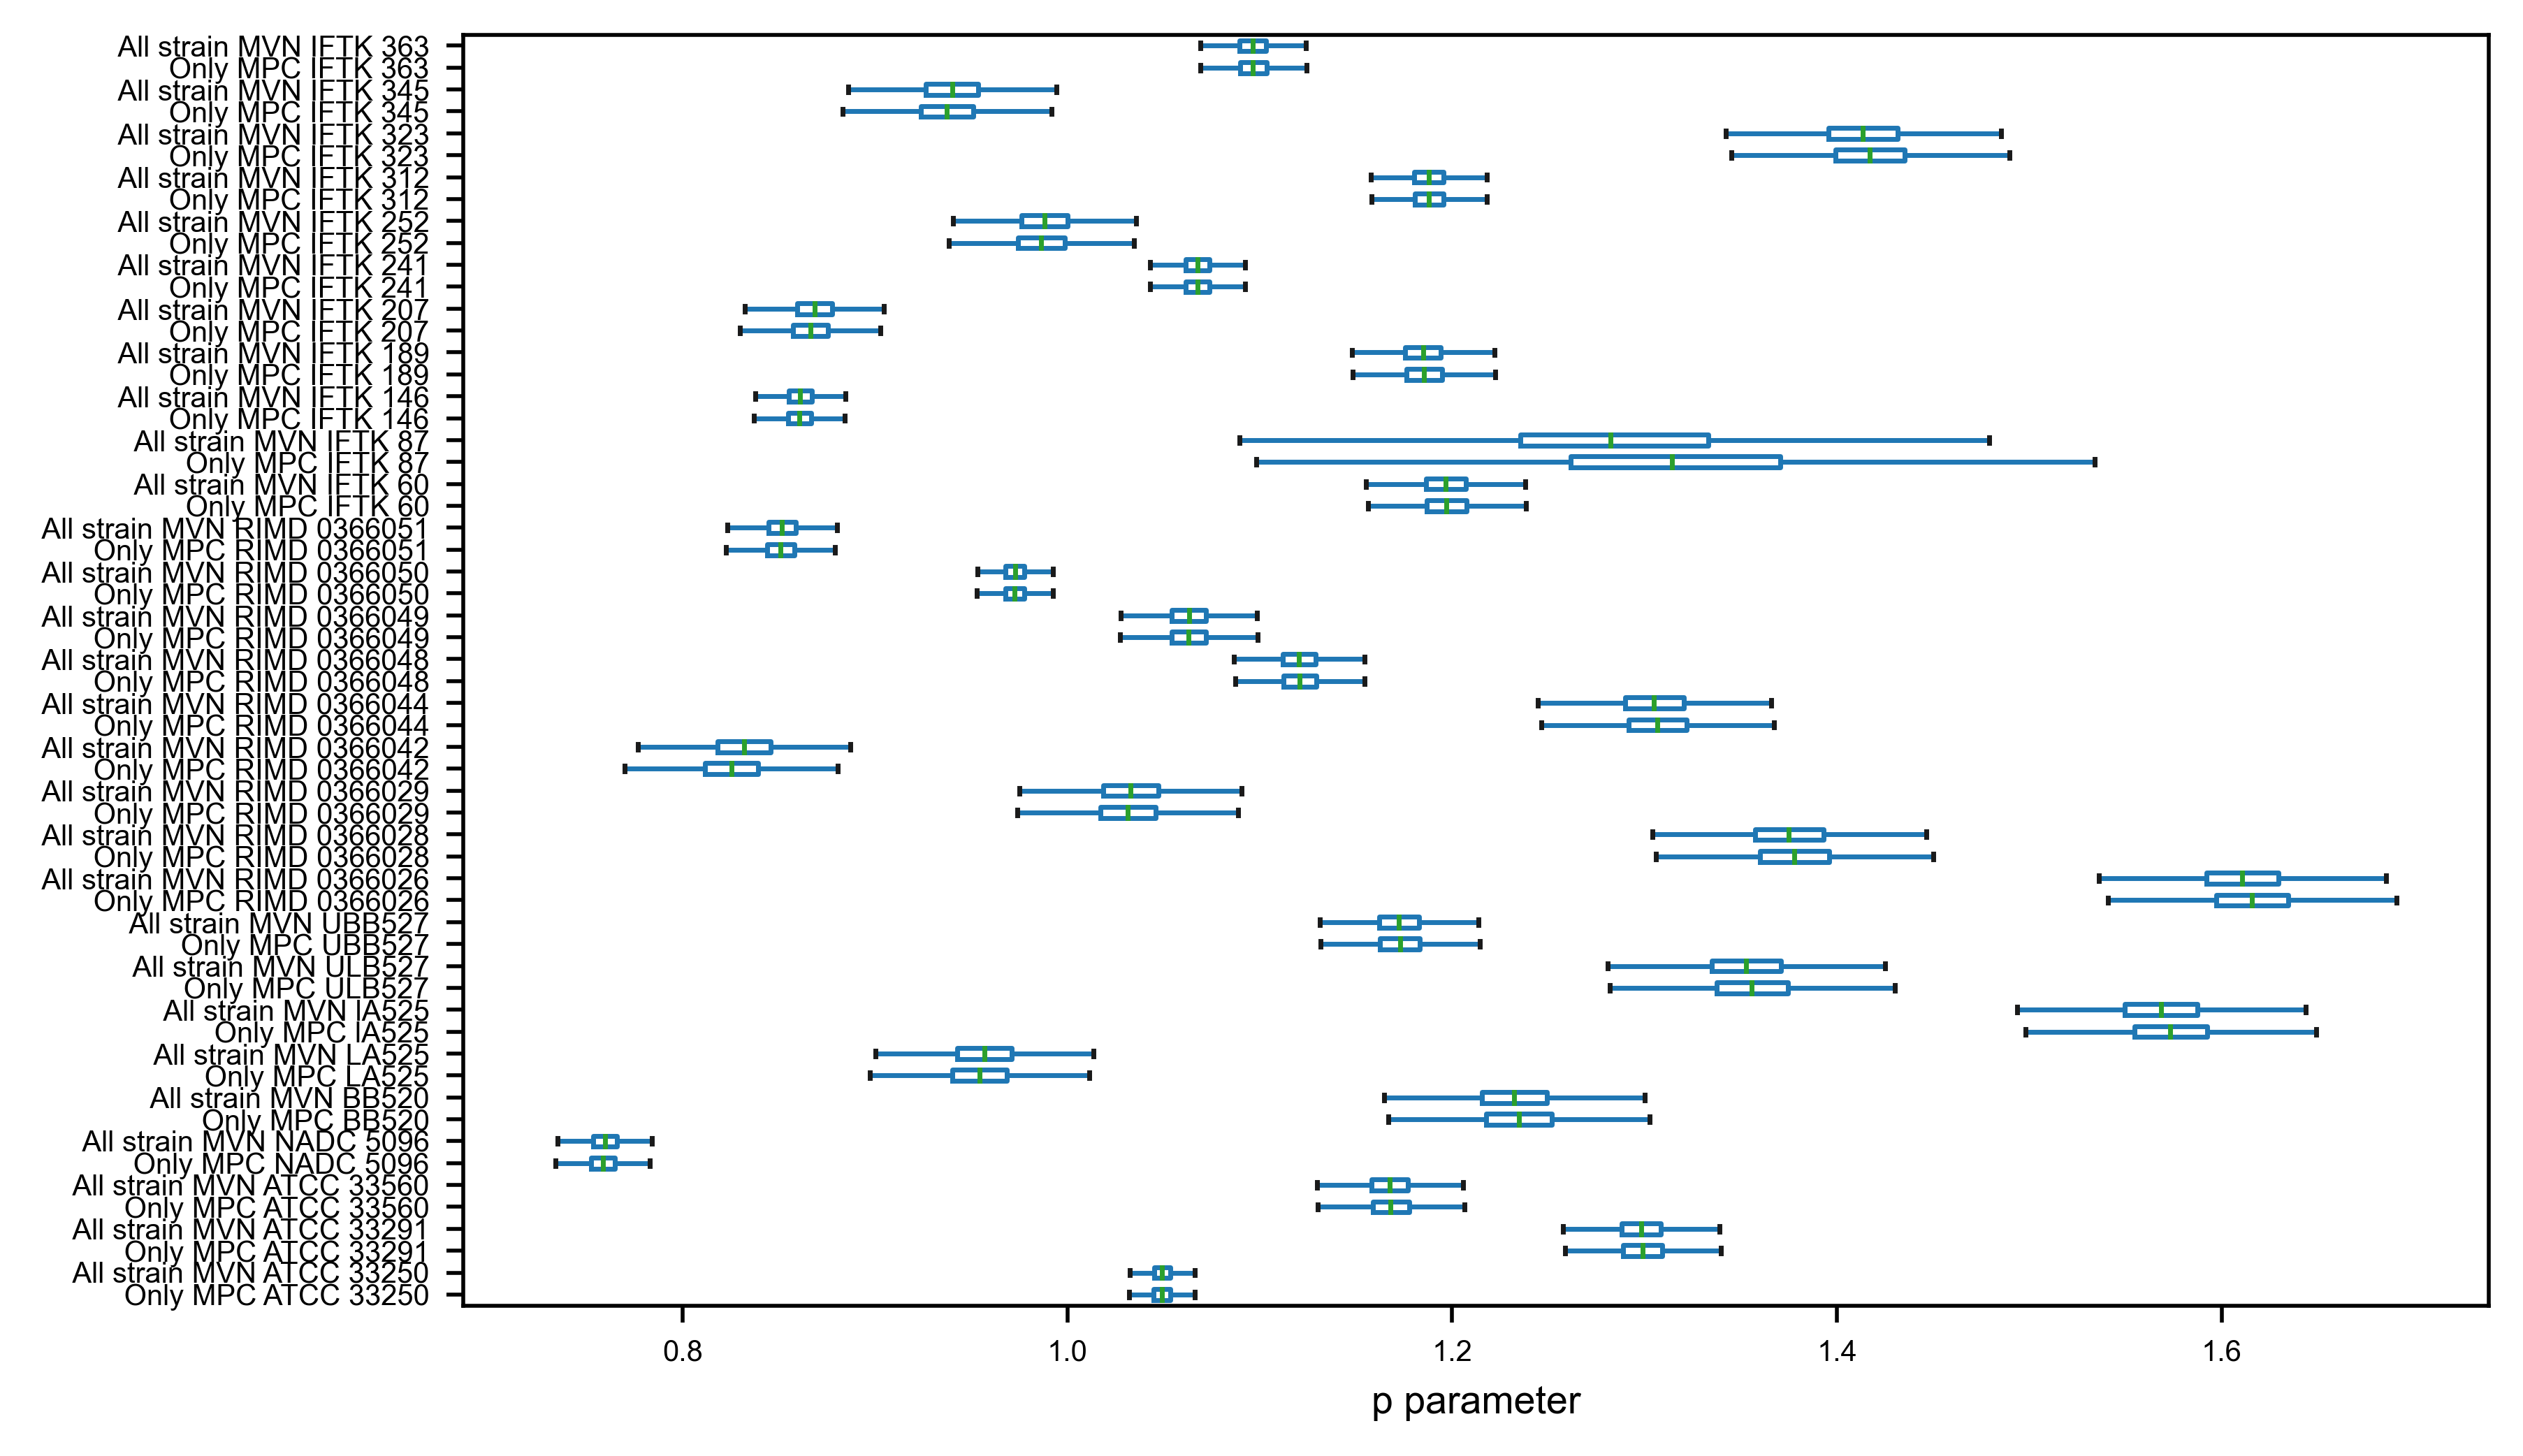

In [33]:
plt.figure(figsize=(19*0.393701,24*0.393701/2), dpi=500)
ComData = pd.DataFrame({" Only MPC "+StrainName[0]:samples_onlyMPC['power'][:,0]," All strain MVN "+StrainName[0]:samples_allMVN['power'][:,0]})

for i in range(1,StrainCount):
    ComData[" Only MPC "+StrainName[i]]=samples_onlyMPC['power'][:,i]
    ComData[" All strain MVN "+StrainName[i]]=samples_allMVN['power'][:,i]
ComData.boxplot(vert=False,sym = ".", showfliers = False,grid=False)
plt.xticks(size=6)
plt.yticks(size=6)
plt.xlabel("p parameter",size=8,fontname="Arial")
plt.savefig("Figures/Fig. S2b.pdf", bbox_inches="tight", dpi=500)
plt.show()

In [34]:
time = [0.0, 2.25, 4.5, 6.75, 9.0, 11.25]
Means = np.empty([StrainCount, 6])
Stds = np.empty([StrainCount, 6])

for l in range(StrainCount):
    mean = np.empty(6)
    std = np.empty(6)
    for i in range(6):
        mean[i] = np.mean(datum[(datum['ID_strain'] == l+1)&(datum['t_heat'] == time[i])]['LogSt'].astype('float'))
        std[i] = np.std(datum[(datum['ID_strain'] == l+1)&(datum['t_heat'] == time[i])]['LogSt'].astype('float'))
    Means[l,:] = mean
    Stds[l,:] = std

In [35]:
zerodata = datum[datum['non_detect']==1]

In [36]:
def Fit_Model(t, delta, power) :
    return -(t/delta)**power

Progress:   0%|          | 0/29 [00:00<?, ?it/s]

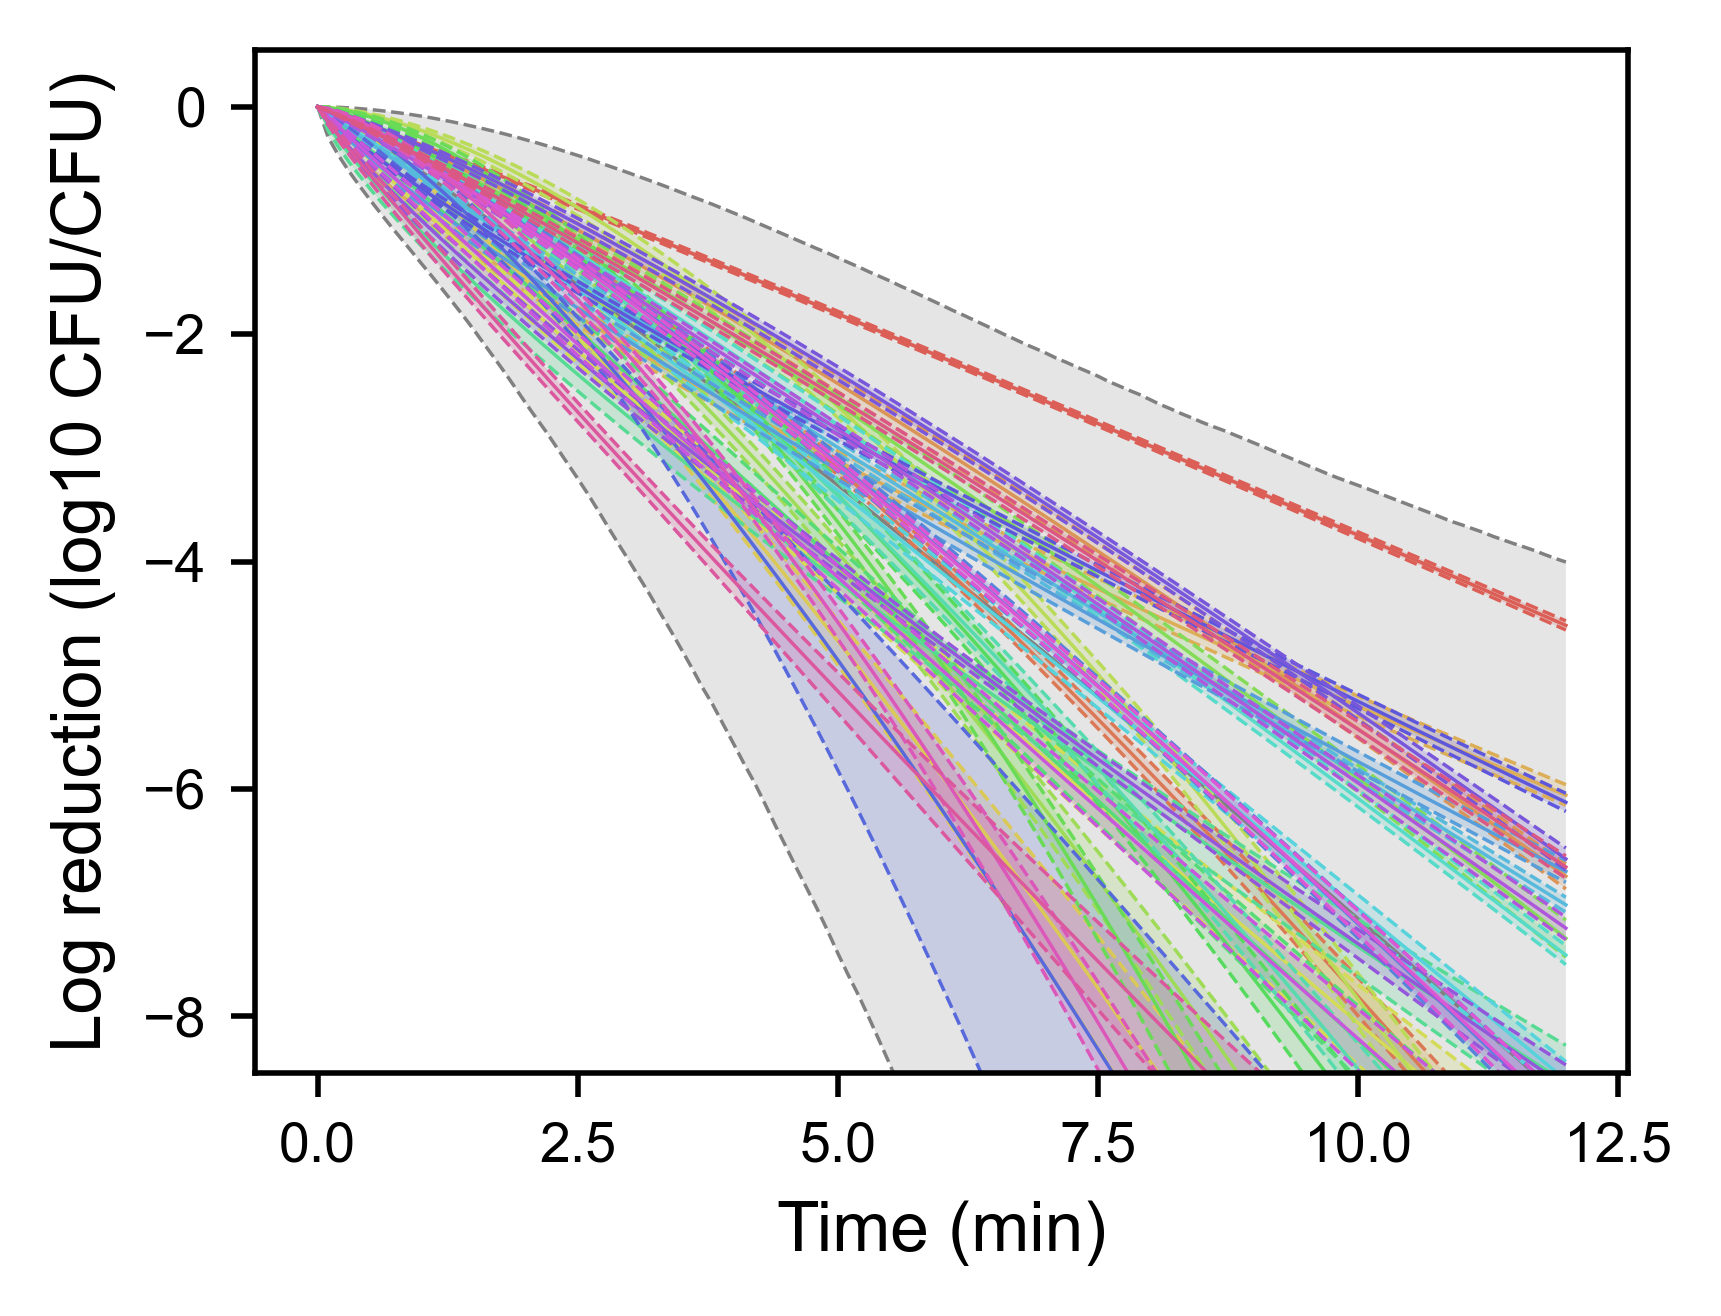

In [37]:
plt.figure(figsize=(9*0.393701,9*0.393701*3/4), dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.xticks(size=8)
plt.yticks(size=8)
plt.xlabel("Time (min)",size=10,fontname="Arial")
plt.ylabel("Log reduction (log10 CFU/CFU)",size=10,fontname="Arial")

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
Num_mcmc = len(samples_onlyMPC["lp__"])
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in range(len(time_interval)):
    for k in range(Num_mcmc):
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j], 
                                            Paras_sim[k,0], Paras_sim[k,1])
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])


plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor="gray", alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color="gray", linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color="gray", linestyle='--', label="Log S credible")
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color="gray")

for i in tqdm(range(1, StrainCount+1),desc='Progress', leave=False):
    StrainNum = i
    
    time_min = 0
    time_max = 12
    devide = (time_max-time_min)*10
    time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                              (time_max-time_min)/devide, dtype="float")
    logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
    logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)
    
    for j in range(len(time_interval)):
        for k in range(Num_mcmc):
            StNum = i-1
            logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])

        logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])
        
    plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
    plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
    plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--', label="Log S credible")
    plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
    

plt.ylim(-8.5,0.5)
plt.savefig("Figures/Fig. 3.pdf", bbox_inches="tight", dpi=500)
plt.show()

In [38]:
StrainNum = 1

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)
plt.xlabel("Time (min)",size=10,fontname="Arial")
plt.ylabel("Log reduction (log10 CFU/CFU)",size=10,fontname="Arial")


plt.savefig("Figures/Fig. S1-legend.pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

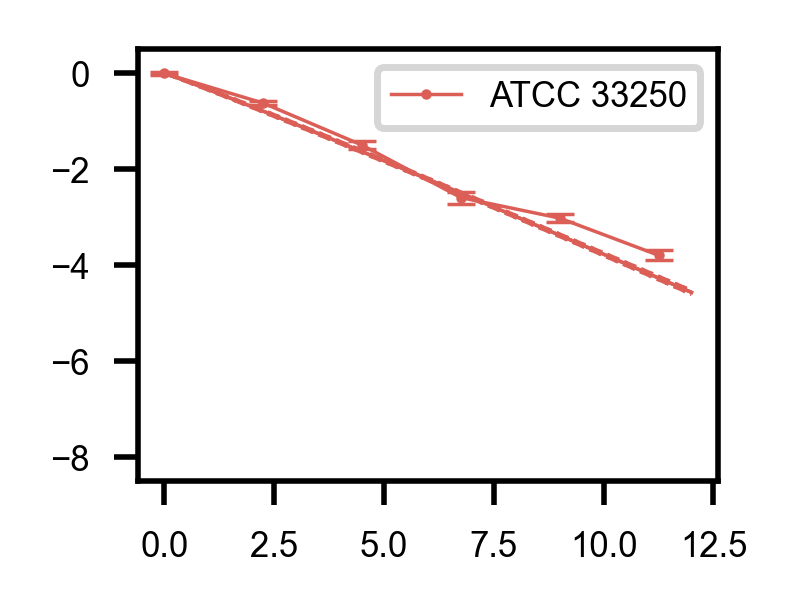

In [39]:
StrainNum = 1

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

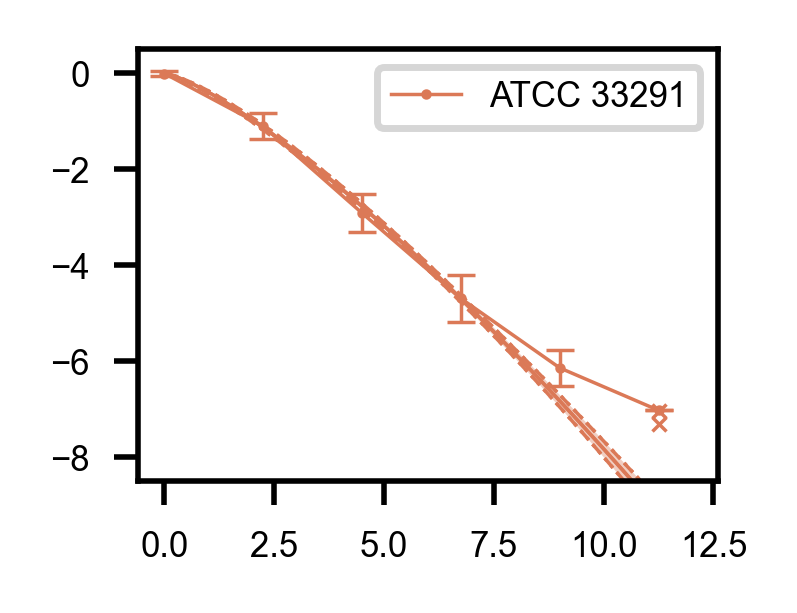

In [40]:
StrainNum = 2

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5,
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

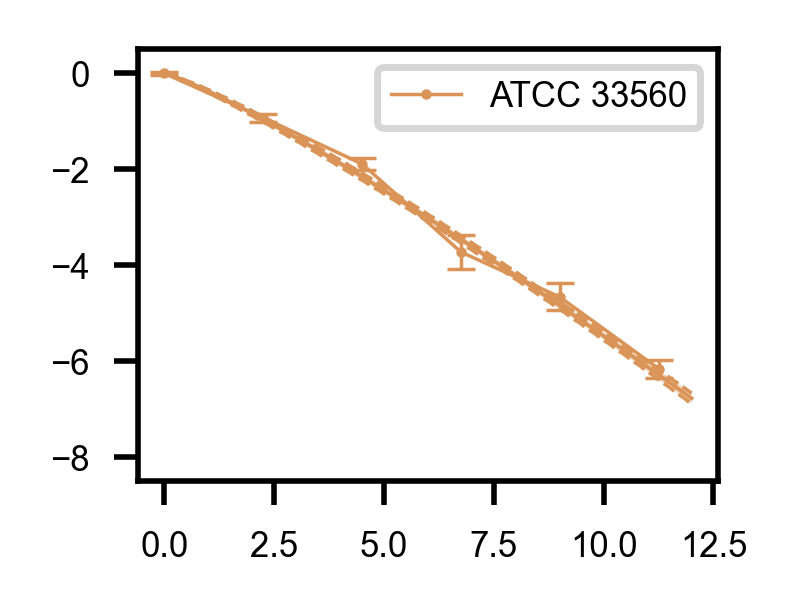

In [41]:
StrainNum = 3

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

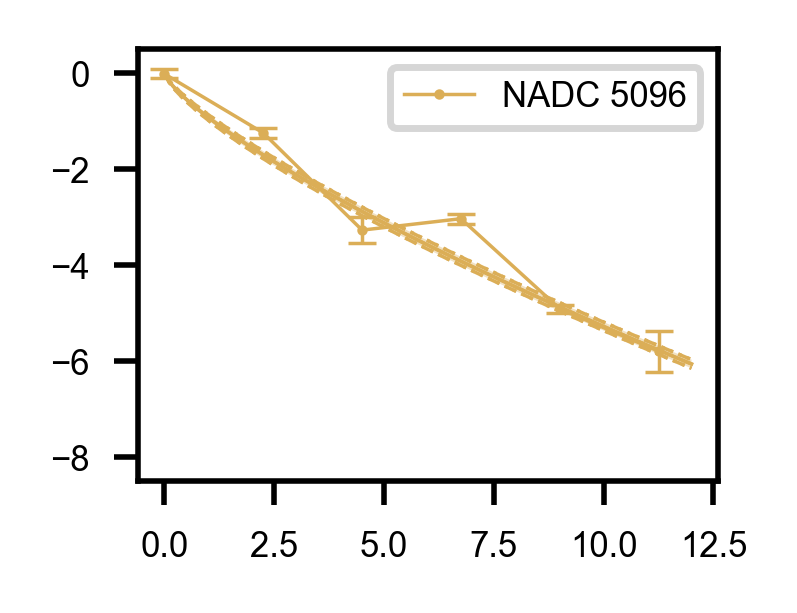

In [42]:
StrainNum = 4

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


In [43]:
StrainNum = 5

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

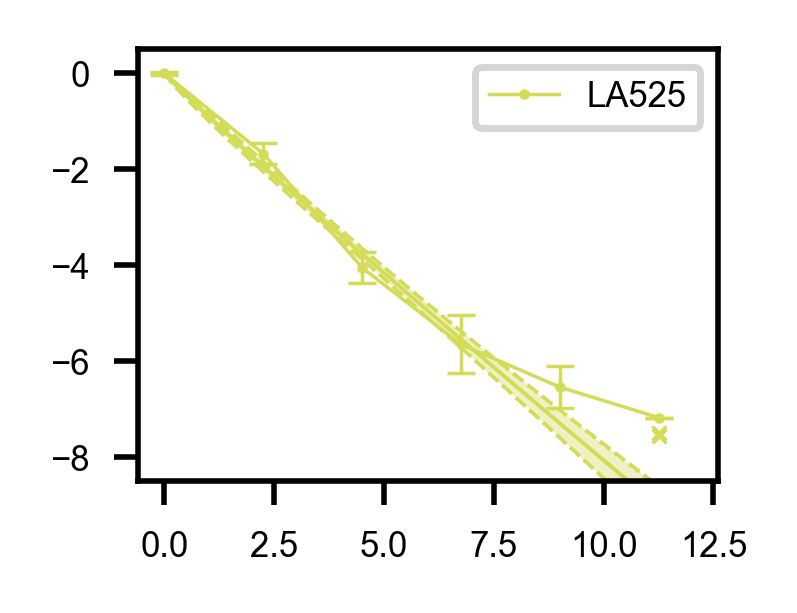

In [44]:
StrainNum = 6

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


In [45]:
StrainNum = 7

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

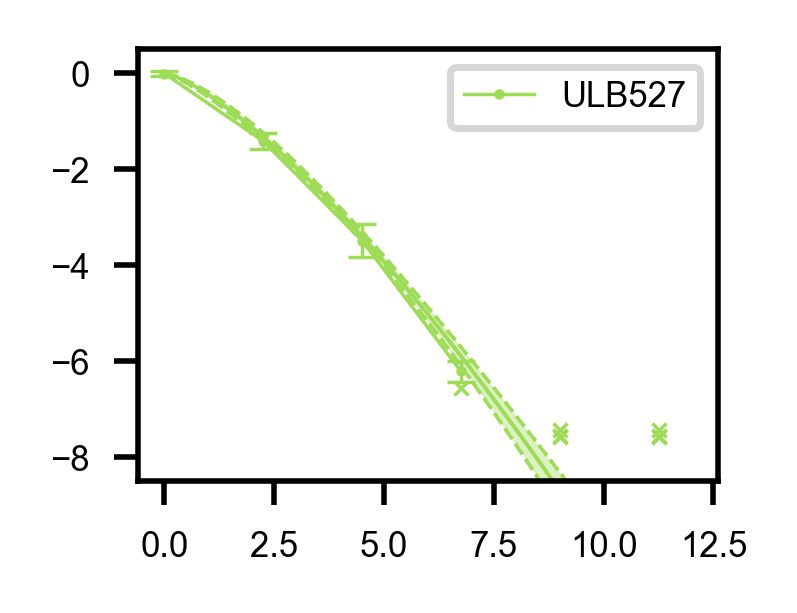

In [46]:
StrainNum = 8

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

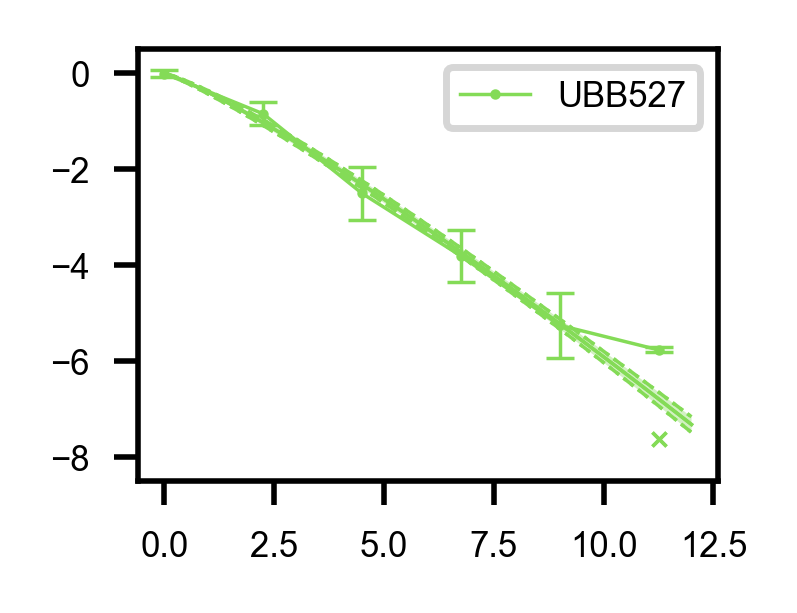

In [47]:
StrainNum = 9

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

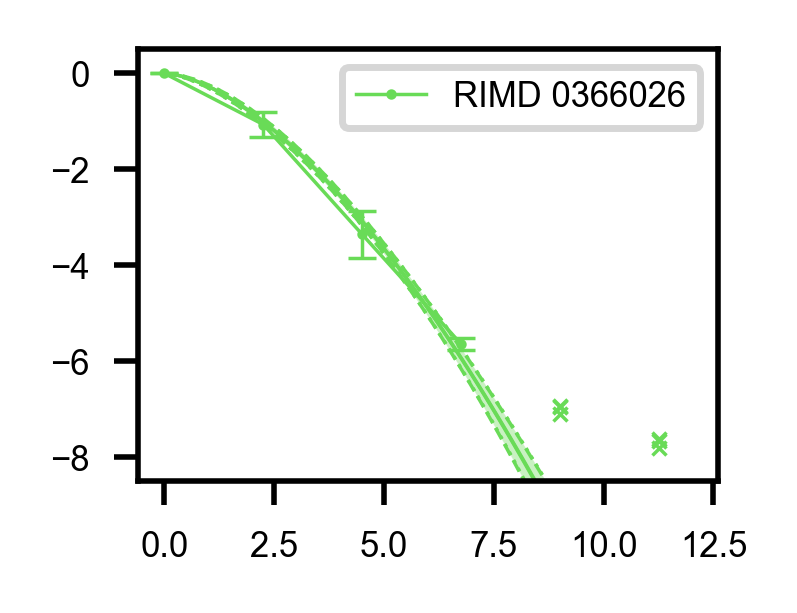

In [48]:
StrainNum = 10

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

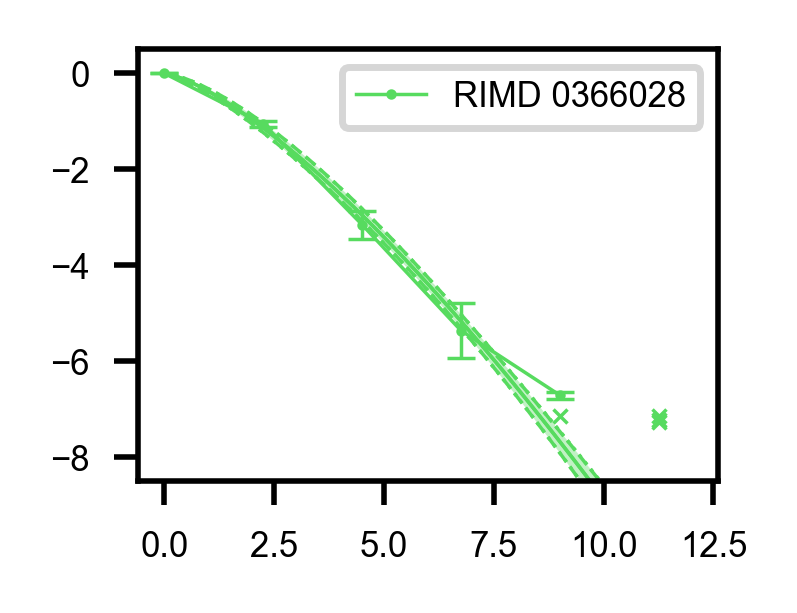

In [49]:
StrainNum = 11

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


In [50]:
StrainNum = 12

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

In [51]:
StrainNum = 13

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

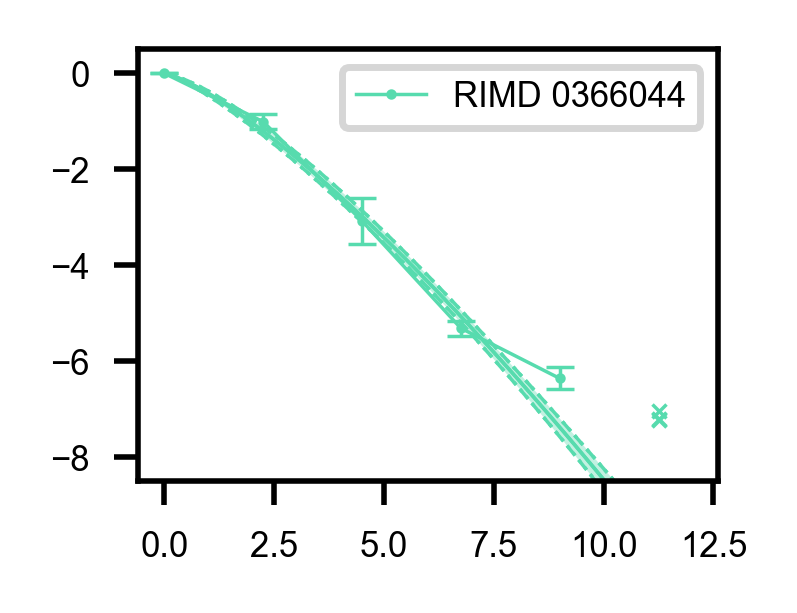

In [52]:
StrainNum = 14

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

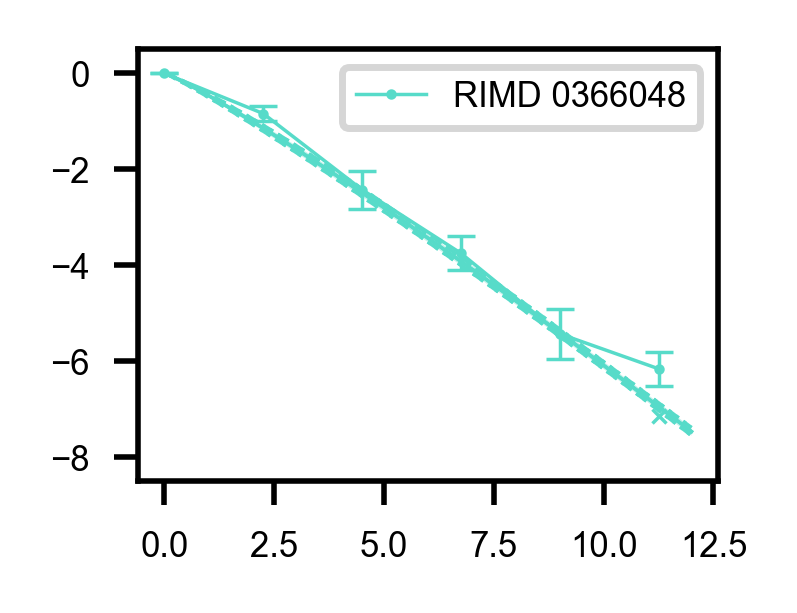

In [53]:
StrainNum = 15

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

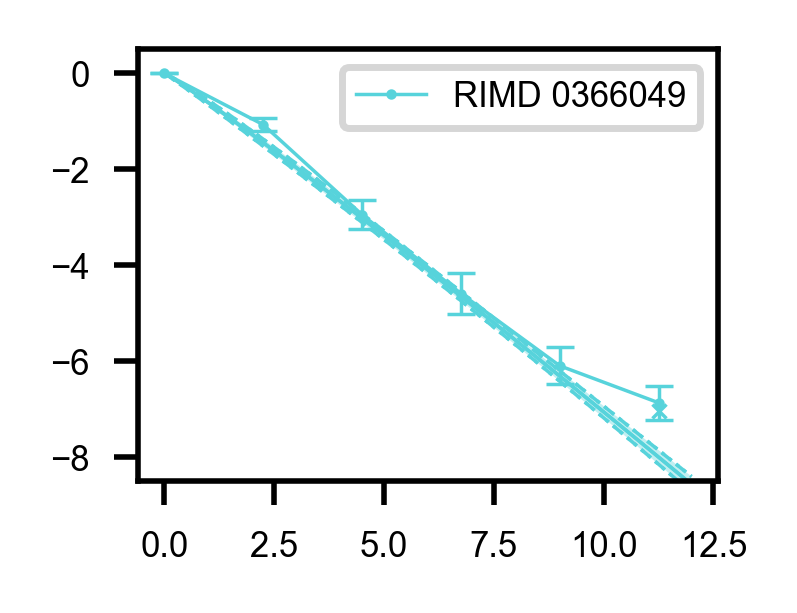

In [54]:
StrainNum = 16

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

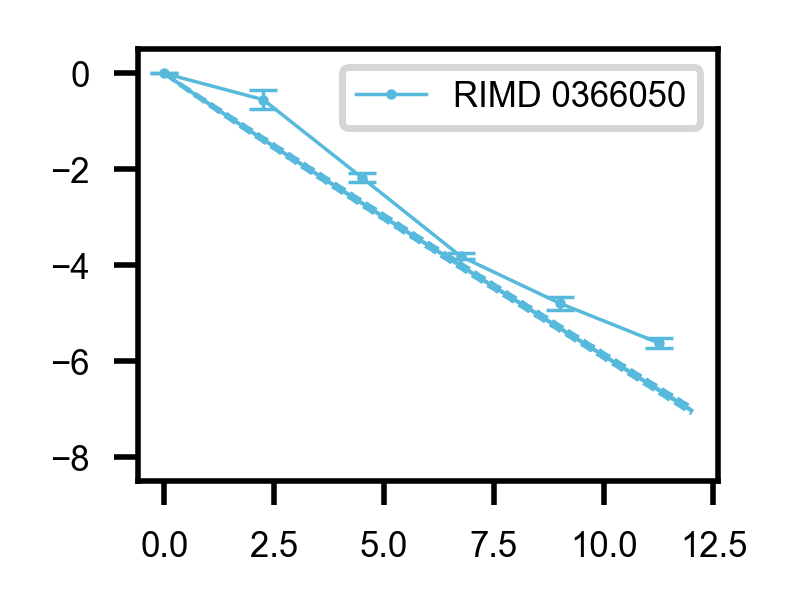

In [55]:
StrainNum = 17

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

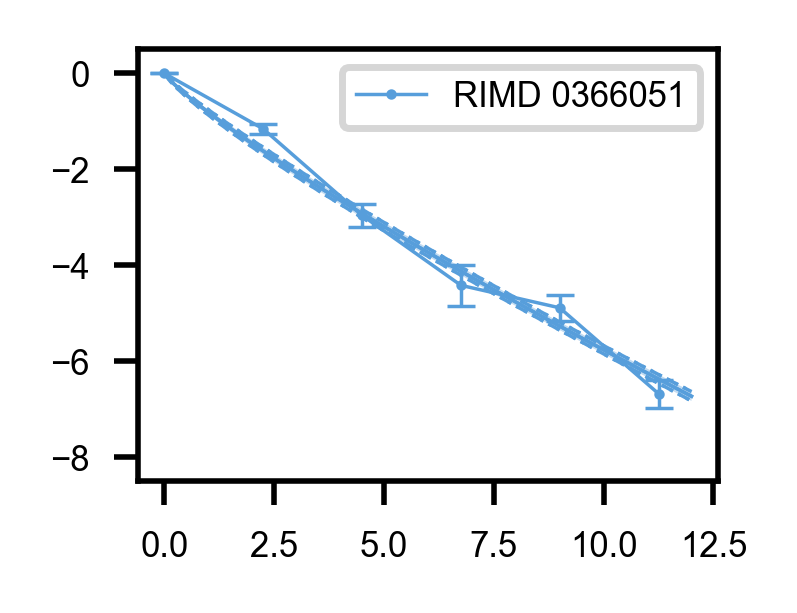

In [56]:
StrainNum = 18

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

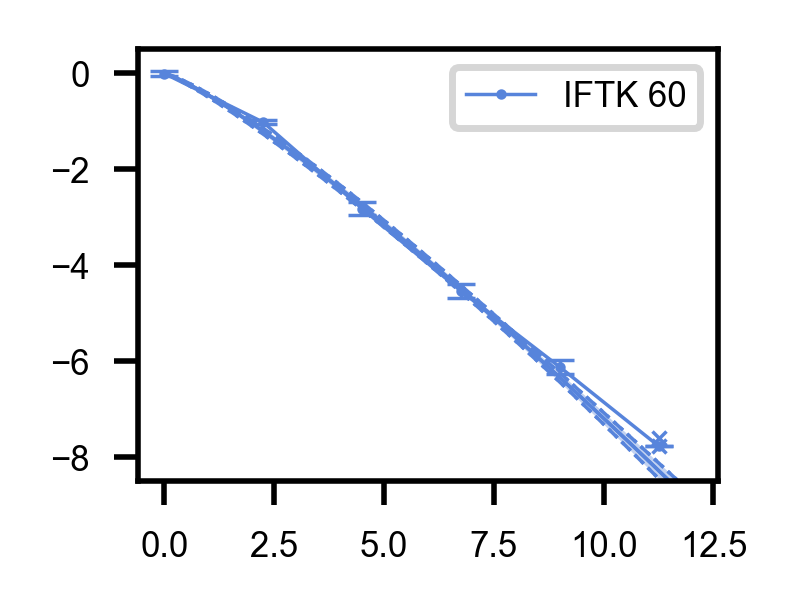

In [57]:
StrainNum = 19

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

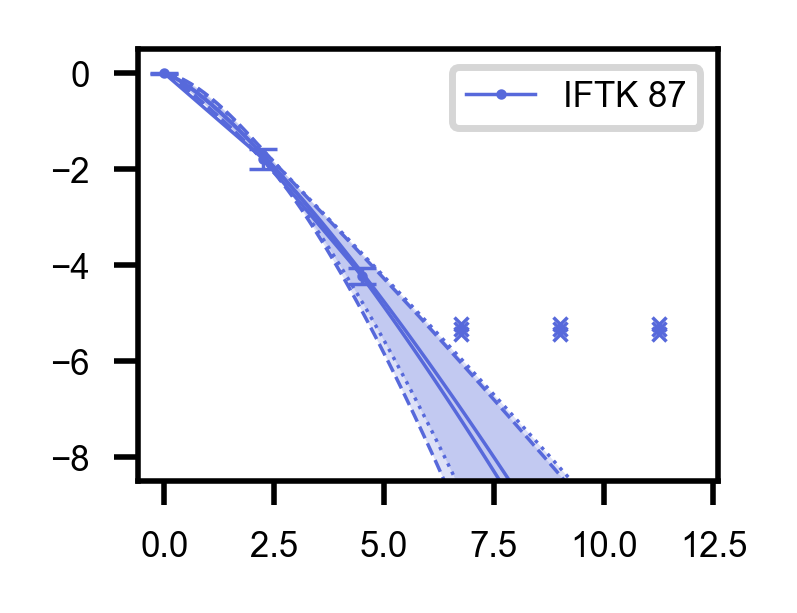

In [58]:
StrainNum = 20

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

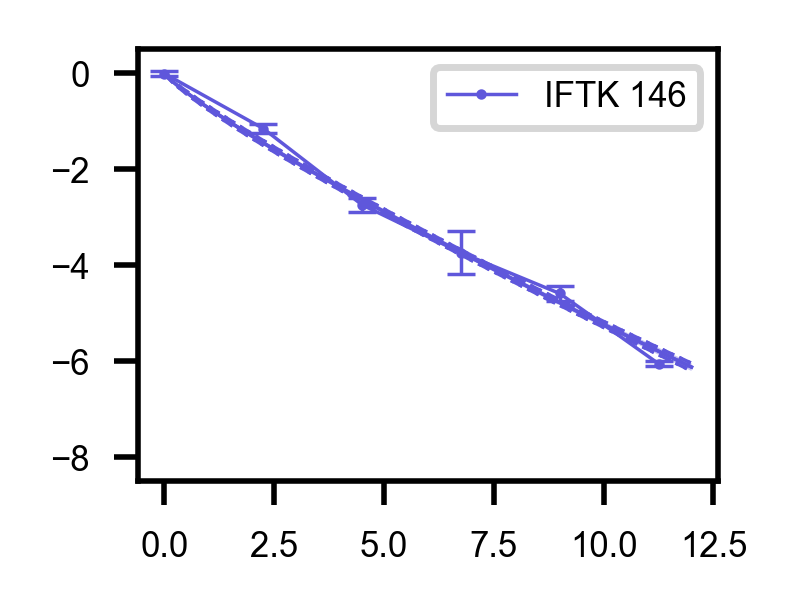

In [59]:
StrainNum = 21

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

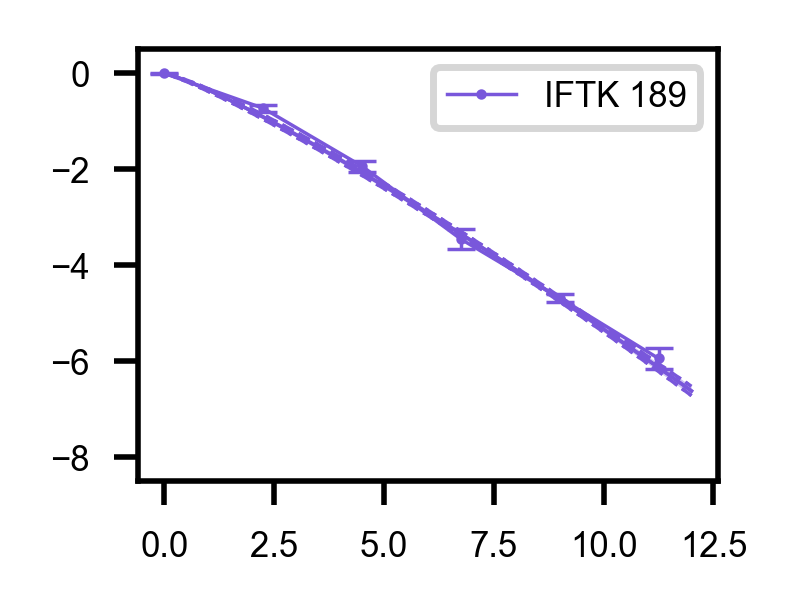

In [60]:
StrainNum = 22

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

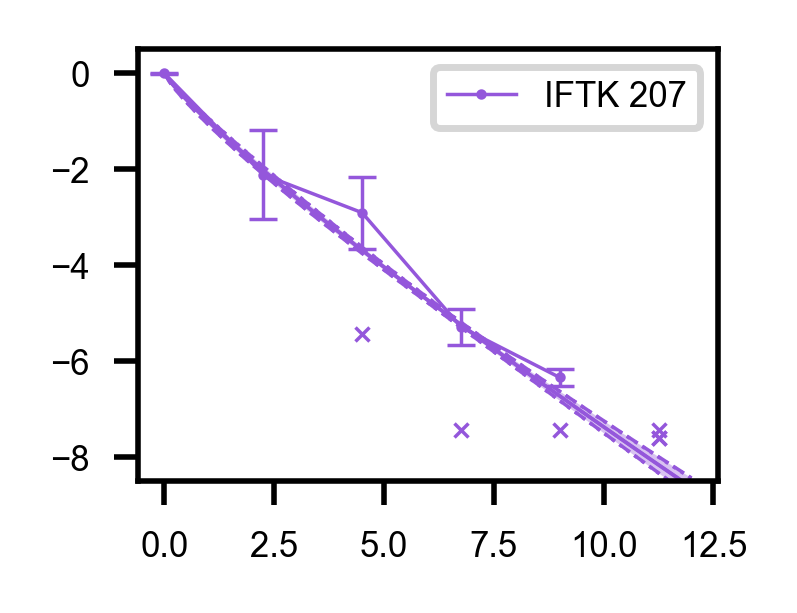

In [61]:
StrainNum = 23

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


In [62]:
StrainNum = 24

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

In [63]:
StrainNum = 25

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

In [64]:
StrainNum = 26

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

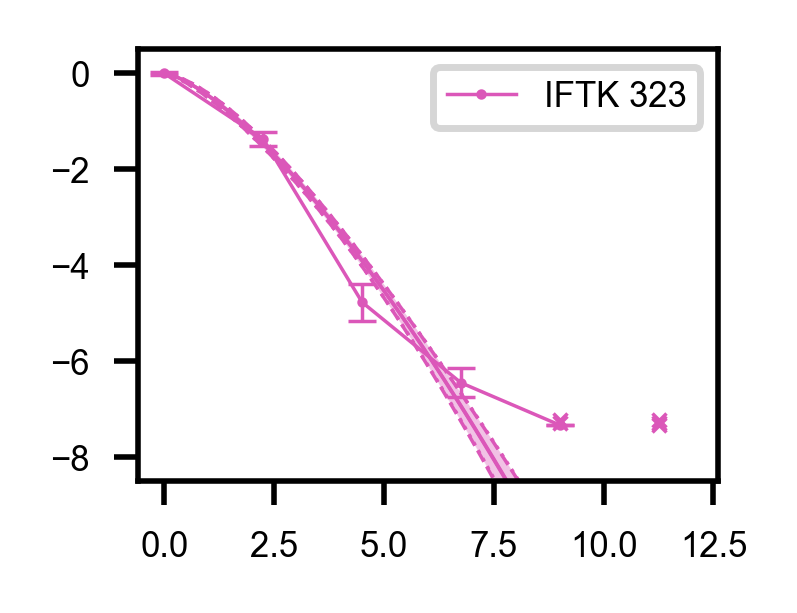

In [65]:
StrainNum = 27

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

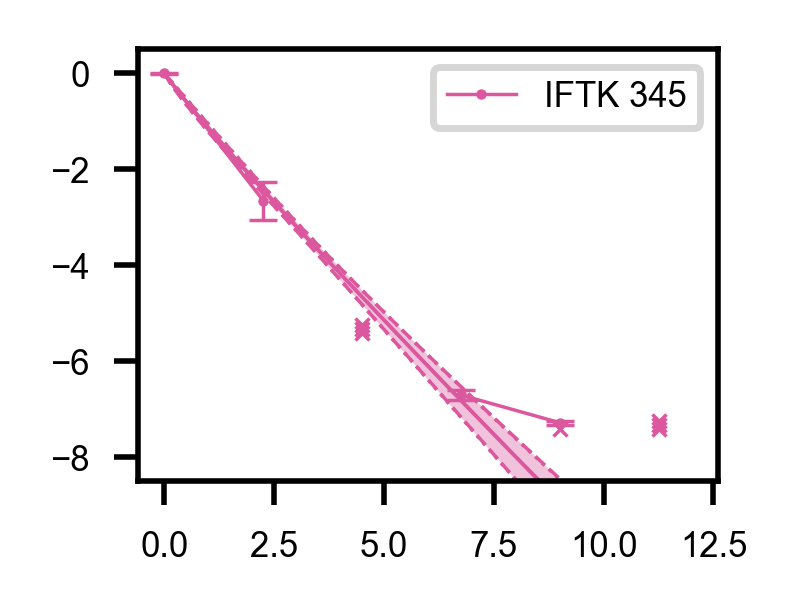

In [66]:
StrainNum = 28

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()


Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

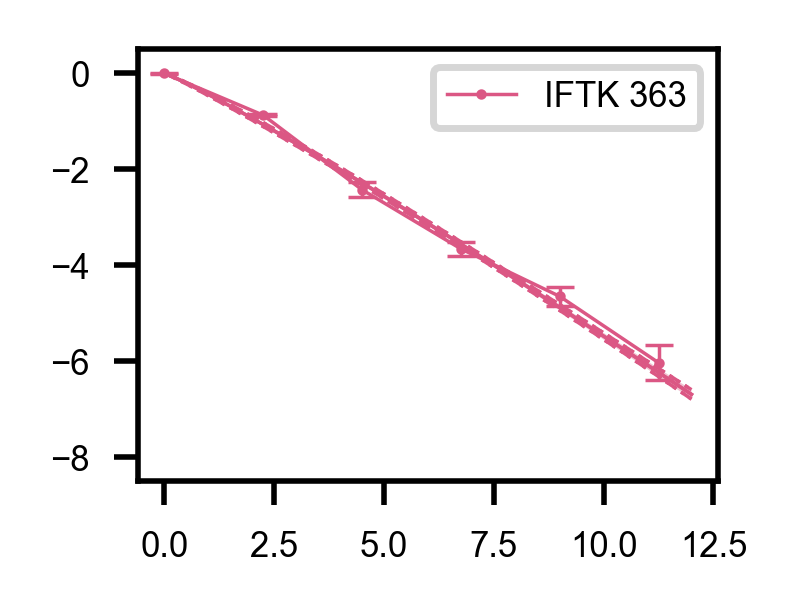

In [67]:
StrainNum = 29

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_onlyMPC["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_onlyMPC["delta"][k, StNum], samples_onlyMPC["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.figure(figsize=[3.8*0.393701, 3.8*0.393701*3/4], dpi=500)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle='--')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
Num_mcmc = len(samples_allMVN["lp__"])
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        StNum = StrainNum-1
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j],samples_allMVN["delta"][k, StNum], samples_allMVN["power"][k, StNum])
        
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[StrainNum-1], alpha=0.2)
plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5, color=Palette[StrainNum-1], linestyle=':')
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5, color=Palette[StrainNum-1])
plt.plot(
    time, Means[StrainNum-1,:], 
    linestyle='-', lw=0.5,
    marker='.', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1], 
    label=StrainName[StrainNum-1]
)
plt.errorbar(
    time,Means[StrainNum-1,:],
    yerr=list(Stds[StrainNum-1,:]),
    fmt="none",elinewidth=0.5,capthick=0.5,
    color=Palette[StrainNum-1],
    capsize = 2
)

zerotime = zerodata[zerodata["ID_strain"]== StrainNum]["t_heat"]
zerolimit = zerodata[zerodata["ID_strain"]== StrainNum]["LogSt_lim"]

plt.plot(
    zerotime, zerolimit, 
    linestyle='', 
    marker='x', 
    ms=2, markeredgewidth=0.5, 
    color=Palette[StrainNum-1]
)

plt.legend(fontsize=5)
plt.ylim(-8.5,0.5)
plt.xticks([0, 2.5, 5.0, 7.5, 10.0, 12.5], size=5)
plt.yticks([-8, -6, -4, -2, 0], size=5)


plt.savefig("Figures/Fig. S1-"+str(StrainNum)+" "+str(StrainName[StrainNum-1])+".pdf", bbox_inches="tight", dpi=500)
plt.show()
